In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:45311")
client

<Client: 'tcp://127.0.0.1:45311' processes=8 threads=40, memory=157.35 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from xhistogram.xarray import histogram as xhist
from xgcm.grid import Grid
import xrft
import s3fs
import gsw

import rioxarray

import glob

import gcm_filters

import seaborn as sns

import os.path as op

from scipy.interpolate import griddata, interpn

# from xeofs.models import EOF
from pydmd import DMD, BOPDMD, MrDMD
from pydmd.mrcosts import mrCOSTS
from pydmd.preprocessing import hankel_preprocessing
from pydmd.plotter import plot_eigs, plot_summary

from matplotlib import ticker
import matplotlib.colors as clr
import matplotlib.pyplot as plt
plt.rcParams['pcolor.shading'] = 'auto'
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
grav = 9.807
meth = 'linear'
sdir = '/tank/spectre/tuchida/SWOT/'
ddir = '/tank/spectre/tuchida/DMD/'

In [5]:
pass16names = [
"SWOT_L3_LR_SSHA_474_016_20230329T104831_20230329T113935_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_476_016_20230331T102945_20230331T112050_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_478_016_20230402T101101_20230402T110206_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_479_016_20230403T100139_20230403T105243_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_481_016_20230405T094254_20230405T103359_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_482_016_20230406T093332_20230406T102437_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_483_016_20230407T092410_20230407T101515_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_484_016_20230408T091449_20230408T100553_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_485_016_20230409T090527_20230409T095631_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_486_016_20230410T085605_20230410T094709_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_487_016_20230411T084643_20230411T093747_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_488_016_20230412T083721_20230412T092826_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_489_016_20230413T082759_20230413T091904_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_490_016_20230414T081837_20230414T090942_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_491_016_20230415T080915_20230415T090019_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_492_016_20230416T075953_20230416T085057_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_493_016_20230417T075031_20230417T084135_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_494_016_20230418T074109_20230418T083213_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_495_016_20230419T073147_20230419T082251_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_496_016_20230420T072224_20230420T081329_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_497_016_20230421T071302_20230421T080407_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_498_016_20230422T070340_20230422T075444_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_499_016_20230423T065418_20230423T074522_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_500_016_20230424T064456_20230424T073600_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_501_016_20230425T063534_20230425T072638_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_502_016_20230426T062612_20230426T071716_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_503_016_20230427T061650_20230427T070754_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_504_016_20230428T060728_20230428T065832_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_505_016_20230429T055805_20230429T064910_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_506_016_20230430T054843_20230430T063947_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_507_016_20230501T053921_20230501T063025_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_508_016_20230502T052958_20230502T062103_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_509_016_20230503T052036_20230503T061141_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_510_016_20230504T051114_20230504T060218_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_511_016_20230505T050152_20230505T055256_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_512_016_20230506T045229_20230506T054334_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_513_016_20230507T044307_20230507T053412_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_514_016_20230508T043345_20230508T052449_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_515_016_20230509T042423_20230509T051527_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_516_016_20230510T041501_20230510T050605_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_517_016_20230511T040538_20230511T045643_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_518_016_20230512T035616_20230512T044720_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_519_016_20230513T034654_20230513T043758_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_520_016_20230514T033731_20230514T042836_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_521_016_20230515T032809_20230515T041913_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_522_016_20230516T031847_20230516T040951_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_523_016_20230517T030924_20230517T040029_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_524_016_20230518T030002_20230518T035106_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_525_016_20230519T025040_20230519T034144_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_529_016_20230523T021312_20230523T030416_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_530_016_20230524T020350_20230524T025454_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_531_016_20230525T015428_20230525T024532_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_532_016_20230526T014506_20230526T023610_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_533_016_20230527T013544_20230527T022648_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_534_016_20230528T012621_20230528T021726_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_535_016_20230529T011659_20230529T020804_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_536_016_20230530T010737_20230530T015841_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_537_016_20230531T005815_20230531T014919_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_538_016_20230601T004852_20230601T013957_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_539_016_20230602T003930_20230602T013035_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_540_016_20230603T003008_20230603T012112_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_541_016_20230604T002046_20230604T011150_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_542_016_20230605T001124_20230605T010228_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_543_016_20230606T000202_20230606T005306_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_544_016_20230606T235240_20230607T004344_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_545_016_20230607T234318_20230608T003422_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_546_016_20230608T233355_20230609T002500_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_547_016_20230609T232433_20230610T001538_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_548_016_20230610T231511_20230611T000615_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_549_016_20230611T230549_20230611T235653_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_550_016_20230612T225626_20230612T234731_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_551_016_20230613T224704_20230613T233808_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_552_016_20230614T223742_20230614T232846_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_553_016_20230615T222819_20230615T231924_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_554_016_20230616T221857_20230616T231001_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_555_016_20230617T220935_20230617T230040_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_556_016_20230618T220013_20230618T225118_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_557_016_20230619T215051_20230619T224156_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_558_016_20230620T214129_20230620T223234_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_559_016_20230621T213208_20230621T222312_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_560_016_20230622T212246_20230622T221350_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_561_016_20230623T211323_20230623T220428_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_562_016_20230624T210401_20230624T215506_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_563_016_20230625T205439_20230625T214544_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_564_016_20230626T204517_20230626T213622_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_565_016_20230627T203555_20230627T212700_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_566_016_20230628T202633_20230628T211737_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_567_016_20230629T201711_20230629T210815_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_568_016_20230630T200748_20230630T205853_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_569_016_20230701T195826_20230701T204931_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_570_016_20230702T194905_20230702T204009_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_571_016_20230703T193943_20230703T203047_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_572_016_20230704T193021_20230704T202125_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_573_016_20230705T192058_20230705T201203_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_574_016_20230706T191136_20230706T200241_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_575_016_20230707T190214_20230707T195319_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_576_016_20230708T185252_20230708T194357_v2.0.1_denoised_v3.0.nc",
"SWOT_L3_LR_SSHA_577_016_20230709T184330_20230709T193435_v2.0.1_denoised_v3.0.nc"
]

len(pass16names)

98

In [ ]:
for cc in pass16names:

    fname = (op.join(sdir,'SWOT_calval_L3_LR_ssha_med_campaign/')
             + cc)
    ds = xr.open_dataset(fname)
    # ds.longitude[ds.longitude>180] -= 360
    ds16 = ds.where((ds.latitude>36.2) & (ds.latitude<43),
                    drop=True)
    ds16 = ds16.where((ds16.longitude>0) & (ds16.longitude<6.5),
                      drop=True)
    
    if cc == pass16names[0]:
        dsMS = ds16.ssha_karin_2_filtered_v3
        dsMS.coords["time"] = ds16.time
    else:
        tmp = ds16.ssha_karin_2_filtered_v3
        tmp.coords["time"] = ds16.time
        dsMS = xr.concat([dsMS, tmp
                         ], 'calval')
    ds.close()

print(dsMS)
dsMS.to_dataset(name="ssha_v3").to_zarr(op.join(sdir,
                     '01-day-repeat/MedSea/Pass%03d.zarr' 
                     % 16), mode='w')
dsMS.close()

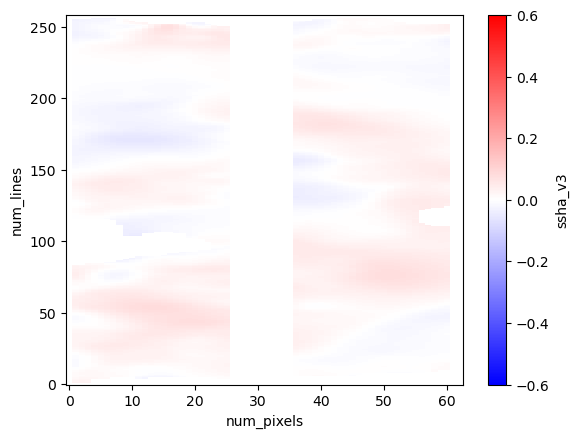

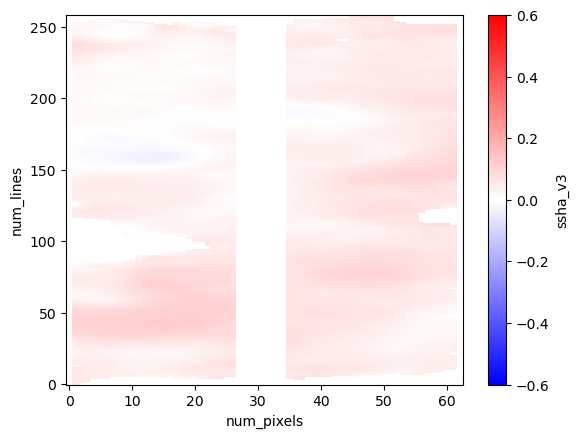

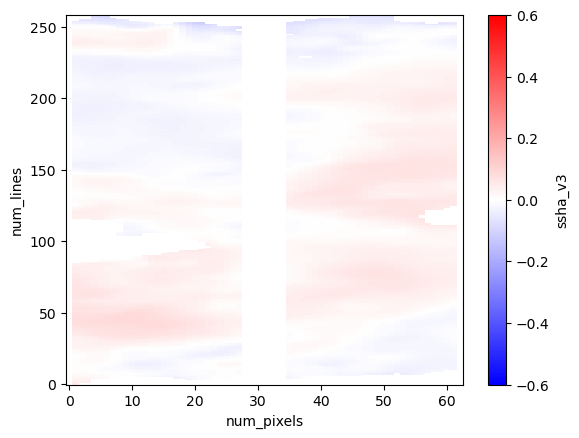

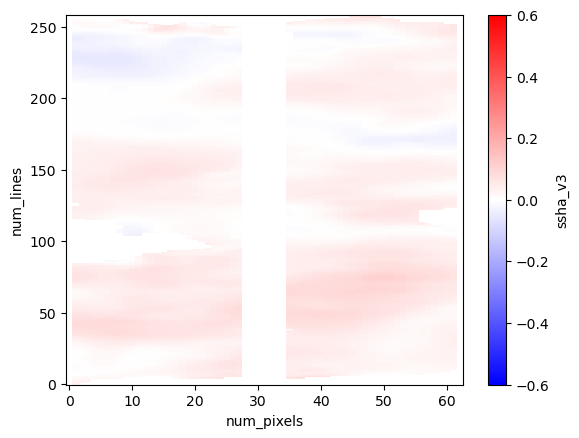

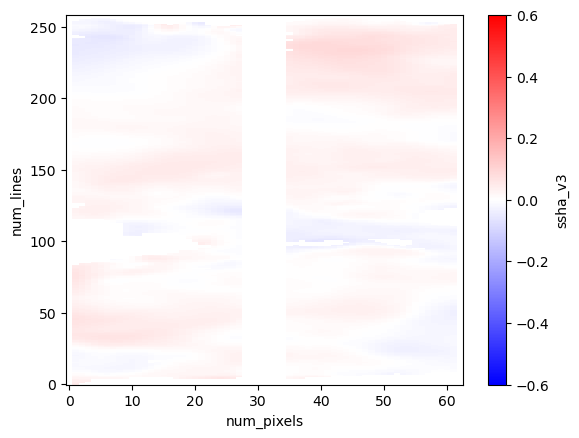

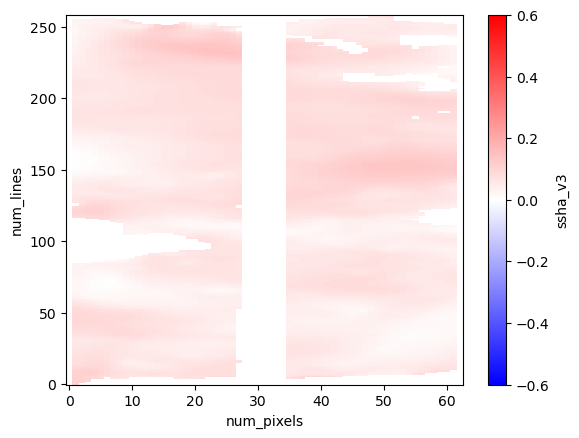

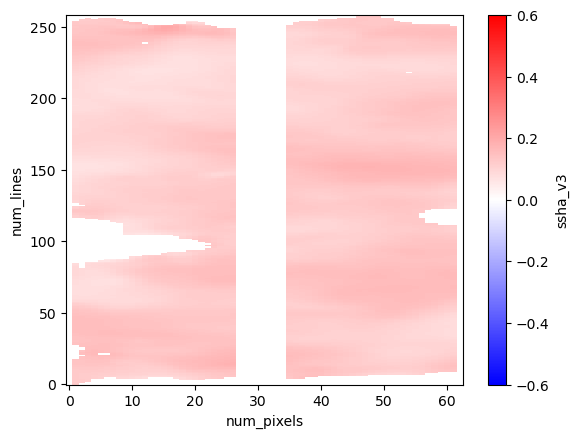

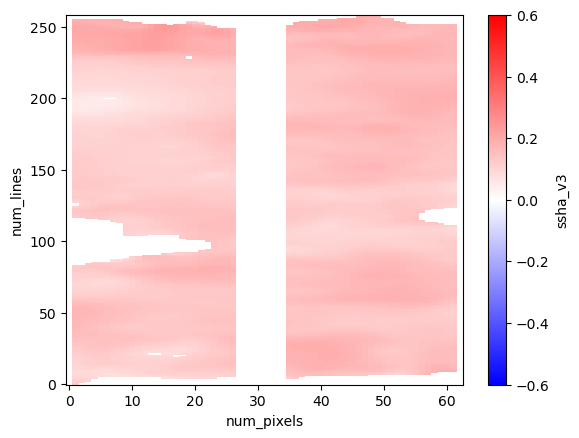

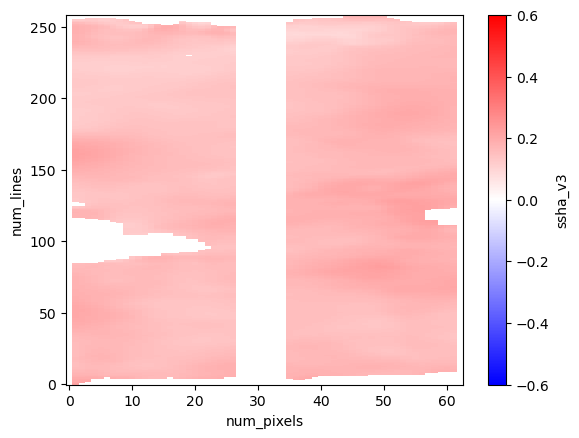

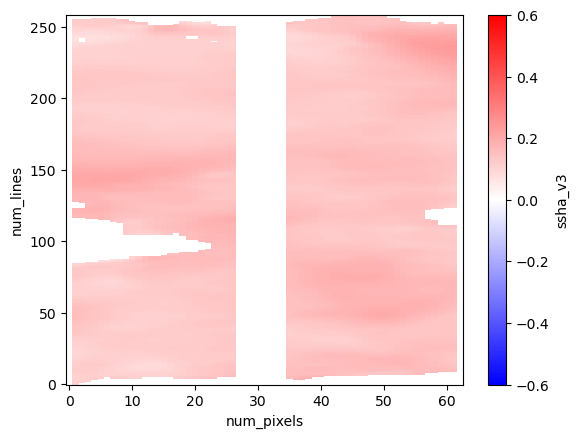

In [40]:
ds16 = xr.open_zarr(op.join(sdir,
                     '01-day-repeat/MedSea/Pass%03d.zarr' 
                     % 16))
for cc in range(0,len(ds16.calval),10):
    ds16.ssha_v3.isel(calval=cc,
                     num_lines=slice(110,369),
                      num_pixels=slice(3,-3)
                    ).plot(rasterized=True, 
                           vmax=.6, vmin=-.6, cmap="bwr")
    plt.show()

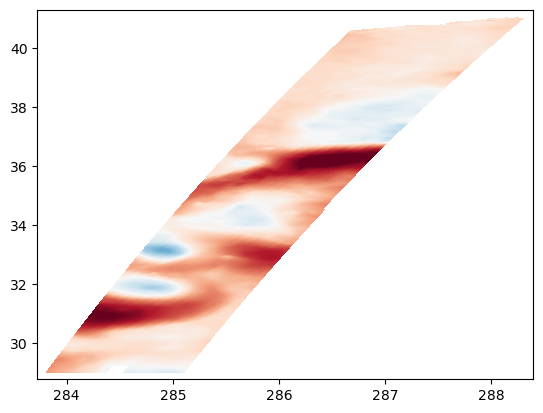

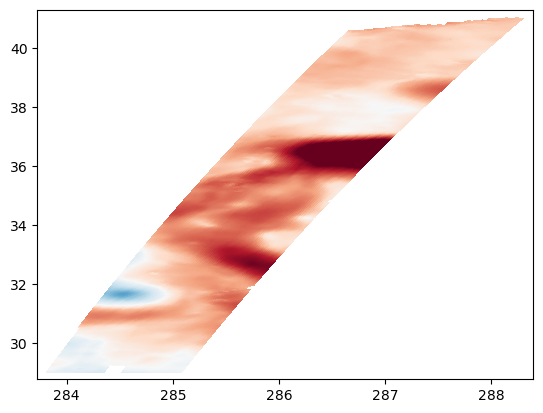

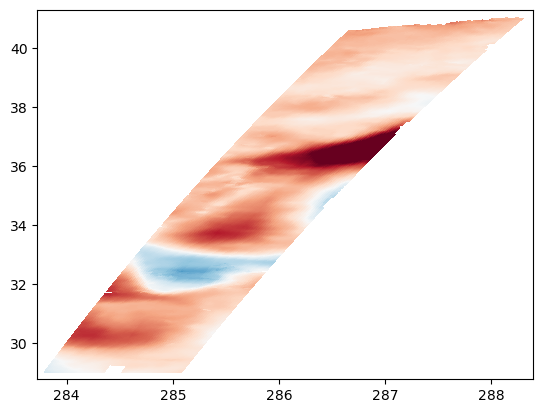

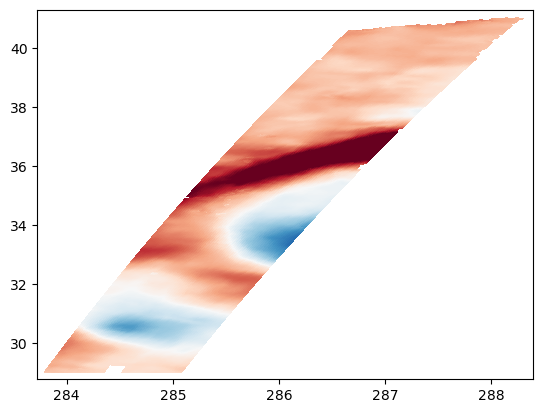

In [41]:
meth = 'linear'
npi = 6
nli = 20

ds3 = xr.open_zarr(op.join(sdir,
                     '01-day-repeat/MedSea/Pass%03d.zarr' 
                     % 3)
                  ).isel(num_lines=slice(40,410),
                         num_pixels=slice(4,-5))
for cc in range(len(ds3.calval)):
    
    ssha = ds2.ssha_v3.chunk({"num_lines":100,
                              "num_pixels":-1}
                            ).reset_coords(drop=True)
    # ssha = dsGS.ssha_karin_2_filtered.interpolate_na(
    #     num_lines=dsGS.num_lines.data,
    #     num_pixels=dsGS.num_pixels.data,
    #     kwargs={"fill_value": "extrapolate"})
    if ssha.ndim > 2:
        ip = 0
        for pp in ssha.pass_num:
            array = dsGS_sub.ssha_karin_2_filtered.sel(pass_num=pp).to_masked_array()
            #get only the valid values
            x1 = dsGS_sub.longitude.sel(pass_num=pp).values[~array.mask]
            y1 = dsGS_sub.latitude.sel(pass_num=pp).values[~array.mask]
            newarr = array[~array.mask]
            ssha[dict(pass_num=ip,
                      num_pixels=slice(npi,-npi),
                      num_lines=slice(nli,-nli))
                ] = griddata((y1,x1),
                             newarr.flatten(), 
                             (dsGS_sub.latitude.sel(pass_num=pp).values,
                             dsGS_sub.longitude.sel(pass_num=pp).values), 
                             method=meth, 
                           # fill_value=0.
                            )
            ip += 1
        # ssha = xr.concat([xr.concat([dsGS.ssha_karin_2_filtered.isel(num_pixels=slice(None,np),
        #                                                          num_lines=slice(nl,-nl)
        #                                                         ).reset_coords(drop=True),
        #                              ssha],'num_pixels'), 
        #                   dsGS.ssha_karin_2_filtered.sel(pass_num=pp
        #                                                 ).isel(num_pixels=slice(-np,None),
        #                                                        num_lines=slice(nl,-nl)
        #                                                       ).reset_coords(drop=True)
        #                  ],'num_pixels')
        # ssha = xr.concat([xr.concat([dsGS.ssha_karin_2_filtered.isel(
        #                                                     num_lines=slice(None,nl)
        #                                                         ).reset_coords(drop=True),
        #                              ssha],'num_lines'), 
        #                   dsGS.ssha_karin_2_filtered.sel(pass_num=pp
        #                                                 ).isel(num_lines=slice(-nl,None)
        #                                                       ).reset_coords(drop=True)
        #                  ],'num_lines'
        #                 ).chunk({"num_lines":100,
        #                          "num_pixels":-1}
        #                        )
            # ssha[dict(pass_num=pp)
            # ] = interpn((dsGS.num_lines.data, dsGS.num_pixels.data),
            #             dsGS.ssha_karin_2_filtered.sel(pass_num=pp).values,
            #             (dsGS.num_lines.data, dsGS.num_pixels.data),
            #             fill_value=None
            #            )
        if cc % 20 == 0:
            fig, ax = plt.subplots()
            ax.pcolor(dsGS.longitude.sel(pass_num=9), 
                      dsGS.latitude.sel(pass_num=9),
                      ssha.sel(pass_num=9),
                      vmax=.4, vmin=-.4, cmap='RdBu_r',
                      rasterized=True)
                    # ax.set_ylim([30,40])
                    # ax.set_xlim([360-78,360-68])
            plt.show()
        dsave = xr.DataArray(ssha.data, dims=['pass_num','num_lines','num_pixels'],
                             coords={'pass_num':dsGS.pass_num.values}
                            ).to_dataset(name='ssha')
        # dsave.coords['latitude'] = dsGS.latitude.chunk({"num_lines":100,"num_pixels":-1})
        # dsave.coords['longitude'] = dsGS.longitude.chunk({"num_lines":100,"num_pixels":-1})
        fname = op.join(sdir,
                        '01-day-repeat/GulfStream/Cyc-num%03d_' % cc.values
                       )+meth+'filtered.zarr' 
        # print(fname)
        dsave.to_zarr(fname, mode='w'
                     )
        dsave.close()
    else:
        if dsGS_sub.pass_num == 9:
            array = dsGS_sub.ssha_karin_2_filtered.to_masked_array()
            #get only the valid values
            x1 = dsGS_sub.longitude.values[~array.mask]
            y1 = dsGS_sub.latitude.values[~array.mask]
            newarr = array[~array.mask]
            ssha[dict(num_pixels=slice(npi,-npi),
                      num_lines=slice(nli,-nli))
                ] = griddata((y1,x1),
                             newarr.flatten(), 
                             (dsGS_sub.latitude.values,
                             dsGS_sub.longitude.values), 
                             method=meth,
                               # fill_value=0.
                            )
            # ssha = xr.concat([xr.concat([dsGS.ssha_karin_2_filtered.isel(
            #                                                      num_pixels=slice(None,np),
            #                                                      num_lines=slice(nl,-nl)
            #                                                     ).reset_coords(drop=True),
            #                              ssha],'num_pixels'), 
            #                   dsGS.ssha_karin_2_filtered.isel(num_pixels=slice(-np,None),
            #                                                   num_lines=slice(nl,-nl)
            #                                                  ).reset_coords(drop=True)
            #          ],'num_pixels')
            # ssha = xr.concat([xr.concat([dsGS.ssha_karin_2_filtered.isel(
            #                                                      num_lines=slice(None,nl)
            #                                                     ).reset_coords(drop=True),
            #                              ssha],'num_lines'), 
            #                   dsGS.ssha_karin_2_filtered.isel(num_lines=slice(-nl,None)
            #                                                  ).reset_coords(drop=True)
            #          ],'num_lines'
            #                 ).chunk({"num_lines":100,
            #                          "num_pixels":-1}
            #                        )
            # ssha[:] = interpn((dsGS.num_lines.data, dsGS.num_pixels.data),
            #                   dsGS.ssha_karin_2_filtered.values,
            #                   (dsGS.num_lines.data, dsGS.num_pixels.data),
            #                   fill_value=None
            #                  )
            if cc % 20 == 0:
                fig, ax = plt.subplots()
                ax.pcolor(dsGS.longitude, 
                          dsGS.latitude,
                          ssha,
                          vmax=.4, vmin=-.4, cmap='RdBu_r',
                          rasterized=True)
                        # ax.set_ylim([30,40])
                        # ax.set_xlim([360-78,360-68])
                plt.show()

            dsave = xr.DataArray(ssha.data, dims=['num_lines','num_pixels']
                                ).to_dataset(name='ssha')
            # dsave.coords['latitude'] = dsGS.latitude.chunk({"num_lines":100,"num_pixels":-1})
            # dsave.coords['longitude'] = dsGS.longitude.chunk({"num_lines":100,"num_pixels":-1})
            fname = op.join(sdir,
                            '01-day-repeat/GulfStream/Cyc-num%03d_' % cc.values
                           )+meth+'filtered.zarr' 
            # print(fname)
            dsave.to_zarr(fname, mode='w'
                         )
            dsave.close()
    dsGS.close()

In [18]:
npix = 4
nlin = 40

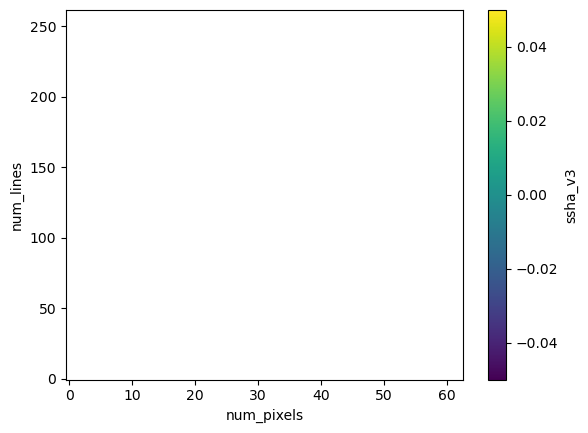

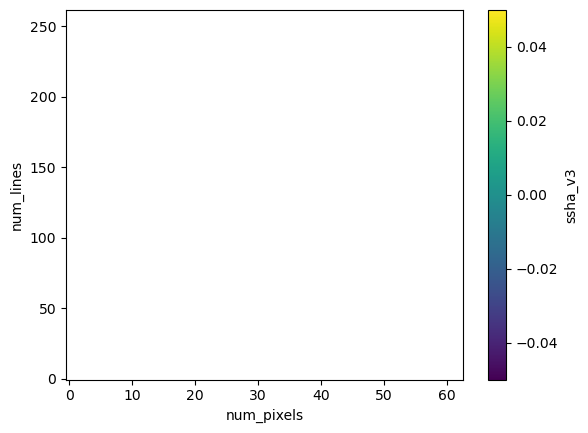

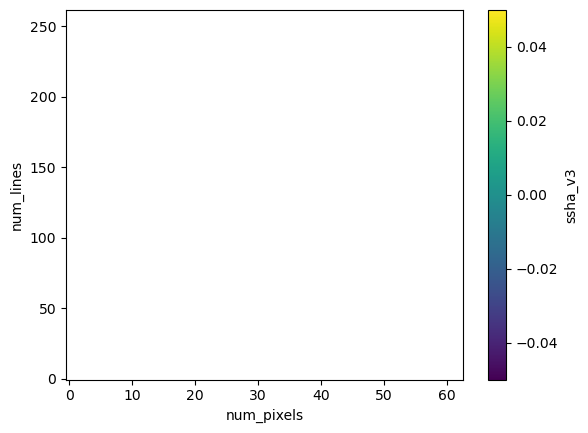

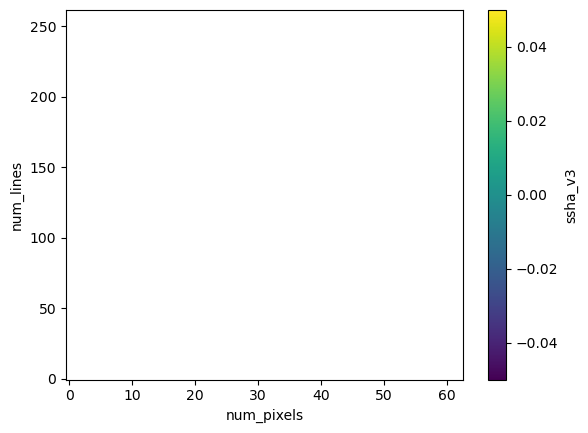

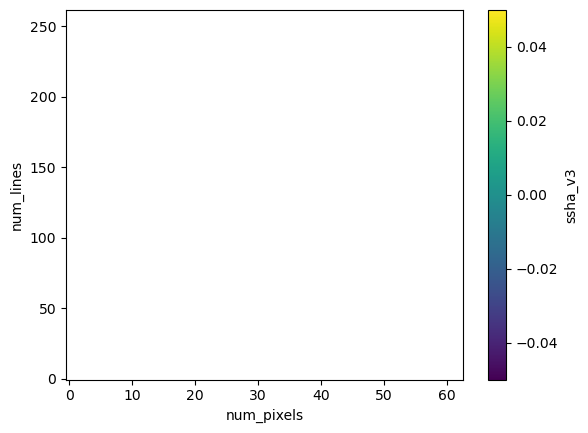

<xarray.DataArray 'ssha_v3' (cycle_num: 93, num_lines: 262, num_pixels: 63)> Size: 12MB
dask.array<concatenate, shape=(93, 262, 63), dtype=float64, chunksize=(1, 101, 32), chunktype=numpy.ndarray>
Coordinates:
  * cycle_num  (cycle_num) int64 744B 0 1 2 3 4 5 6 7 ... 91 92 93 94 95 96 97
    latitude   (num_lines, num_pixels) float64 132kB dask.array<chunksize=(262, 63), meta=np.ndarray>
    longitude  (num_lines, num_pixels) float64 132kB dask.array<chunksize=(262, 63), meta=np.ndarray>
    time       (cycle_num, num_lines, num_pixels) datetime64[ns] 12MB dask.array<chunksize=(2, 94, 32), meta=np.ndarray>
Dimensions without coordinates: num_lines, num_pixels

In [6]:
ic = 0

ds16 = xr.open_zarr(op.join(sdir,
                     '01-day-repeat/MedSea/Pass%03d.zarr' 
                     % 16)
                  ).isel(num_lines=slice(108,370),
                         num_pixels=slice(3,-3)
                        )

for cc in range(len(ds16.calval)):
    
    ssha = ds16.ssha_v3.isel(calval=cc)
    
    array = ssha.to_masked_array()
    mask = ~array.mask
    ratio = mask.sum() / np.prod(mask.shape)
    if ic == 0:
        R16 = xr.DataArray(np.array([ratio]), 
                         dims='cycle_num', 
                         coords={'cycle_num':np.array([cc,])}
                        )
    else:
        R16 = xr.concat([R16, xr.DataArray(np.array([ratio]), 
                           dims='cycle_num', 
                           coords={'cycle_num':np.array([cc,])}
                                      )
                      ], 'cycle_num')
    if ratio > .7:
        if ic == 0:
            H16 = ssha
        else:
            try:
                H16 = xr.concat([H16, ssha], 'cycle_num')
            except:
                pass
        ic += 1
    else:
        ssha.plot(rasterized=True)
        plt.show()
    del ssha, mask, array

H16.coords["cycle_num"] = R16.where(R16>0.7,drop=True).cycle_num
H16

# Tidying up and filtering data

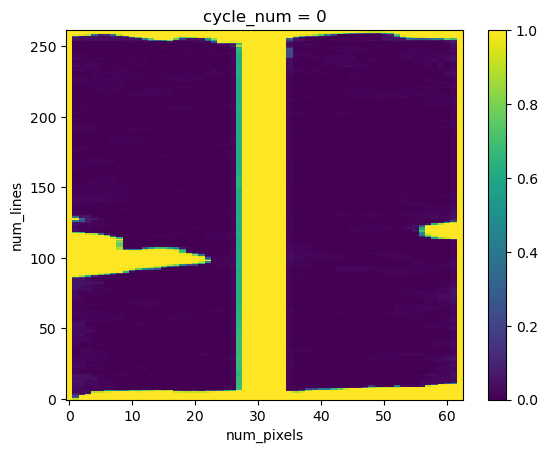

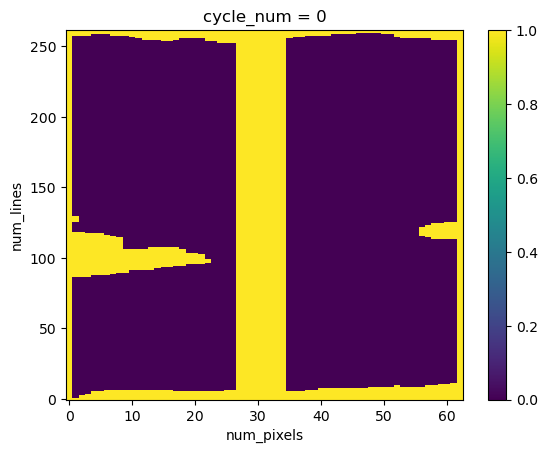

<xarray.DataArray (num_lines: 262, num_pixels: 63)> Size: 17kB
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Coordinates:
    latitude   (num_lines, num_pixels) float64 132kB dask.array<chunksize=(262, 63), meta=np.ndarray>
    longitude  (num_lines, num_pixels) float64 132kB dask.array<chunksize=(262, 63), meta=np.ndarray>
    time       (num_lines, num_pixels) datetime64[ns] 132kB dask.array<chunksize=(94, 32), meta=np.ndarray>
    cycle_num  int64 8B 0
Dimensions without coordinates: num_lines, num_pixels

In [7]:
mask16 = xr.DataArray(H16.to_masked_array().mask.mean(axis=0), 
                      dims=H16.isel(cycle_num=0).dims, 
                      coords=H16.isel(cycle_num=0).coords
                    )
mm16 = xr.DataArray(mask16.where(mask16<.35
                              ).to_masked_array().mask,
                   dims=H16.isel(cycle_num=0).dims, 
                   coords=H16.isel(cycle_num=0).coords
                  )

mask16.plot()
plt.show()
mm16.plot()
plt.show()
mm16

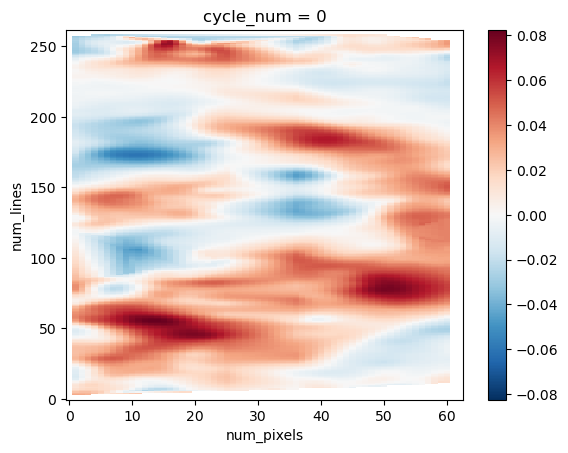

ERROR 1: PROJ: internal_proj_create_from_database: /tank/spectre/tuchida/miniconda3/envs/dmd/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.


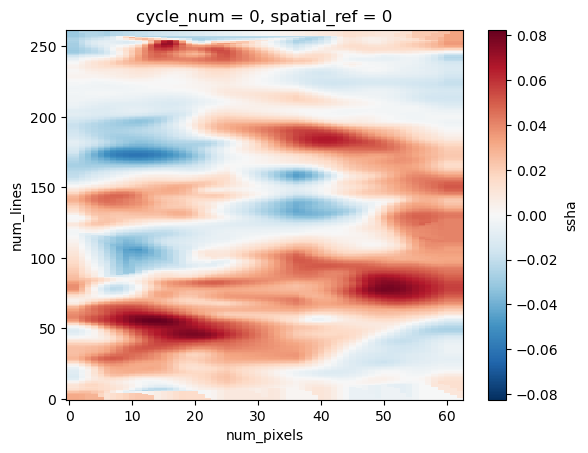

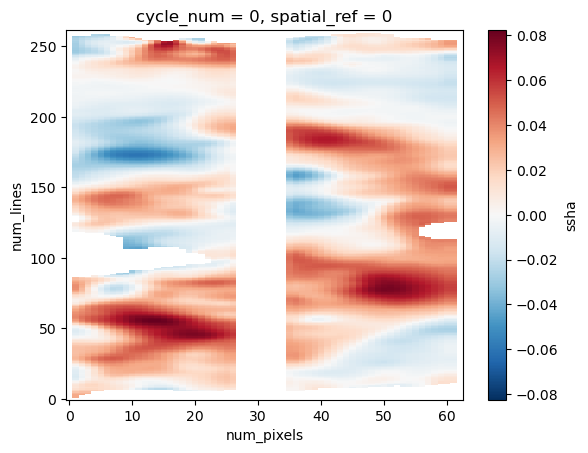

In [8]:
for cc in H16.cycle_num:
    _ssh = H16.sel(cycle_num=cc)

    x1, y1 = np.meshgrid(np.arange(len(H16.num_pixels)),
                         np.arange(len(H16.num_lines))
                        )
    
    array = np.ma.masked_invalid(_ssh)
    # get only the valid values
    _y1 = y1[~array.mask]
    _x1 = x1[~array.mask]
    newarr = array[~array.mask]
    _ssh = xr.DataArray(griddata((_y1,_x1),
                                 newarr.flatten(), 
                                 (y1,x1), 
                                 method=meth,
                                       # fill_value=0.
                                ), 
                        dims=H16.sel(cycle_num=cc).dims,
                        coords=H16.sel(cycle_num=cc).coords
                       )
    if cc == H16.cycle_num[0]:
        H16_interp = _ssh
        _ssh.plot(rasterized=True)
        plt.show()
    else:
        H16_interp = xr.concat([H16_interp,_ssh], "cycle_num")
    
dsH16 = H16_interp.to_dataset(name="ssha").swap_dims({'num_pixels':'x', 'num_lines':'y'}
                                                  ).reset_coords(drop=True)
dsH16.coords["y"] = ("y",range(len(dsH16.y)))
dsH16.coords["x"] = ("x",range(len(dsH16.x)))
if not dsH16.rio.crs:
    dsH16 = dsH16.rio.write_crs("EPSG:4326")
    # dsH3 = dsH3.rio.write_crs("EPSG:3857")
if dsH16.ssha.rio.nodata is None:
    dsH16["ssha"] = dsH16.ssha.rio.write_nodata(np.nan)
_H16_exterp = dsH16.rio.interpolate_na().swap_dims({'x':'num_pixels', 
                                                 'y':'num_lines'}
                                               ).ssha
_H16_exterp.isel(cycle_num=0).plot(rasterized=True)
plt.show()

H16_exterp = _H16_exterp.where(mm16!=1)
H16_exterp.isel(cycle_num=0).plot(rasterized=True)
plt.show()

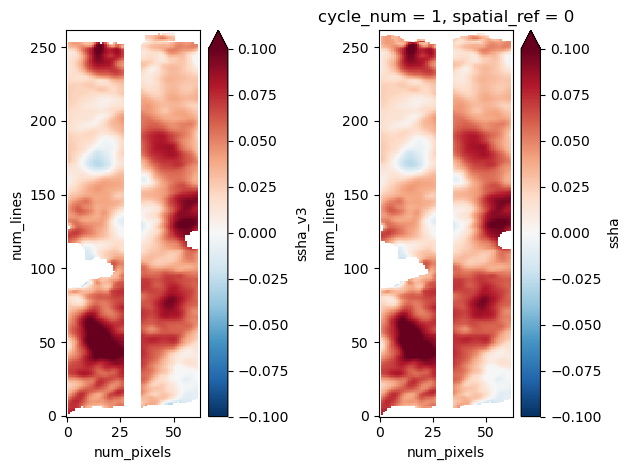

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_tight_layout(True)

ds16.ssha_v3.isel(calval=1).plot(ax=ax1, rasterized=True, vmax=.1)
H16_exterp.isel(cycle_num=1).plot(ax=ax2, rasterized=True, vmax=.1)

In [9]:
iln = 2; ipx = 3
nln = 1; npx = 1

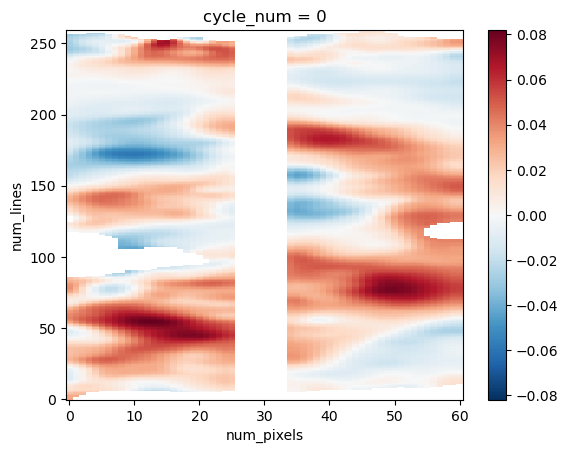

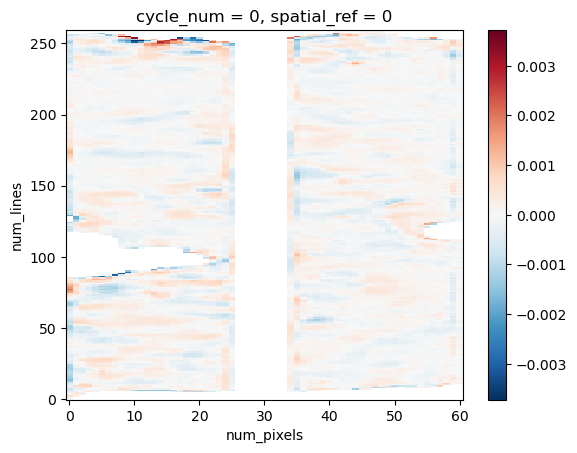

In [19]:
# wet_mask = xr.ones_like(_H3_exterp.isel(cycle_num=0)).reset_coords(drop=True)
# wet_mask[0] = 0
# wet_mask[-1] = 0
# wet_mask[:,0] = 0
# wet_mask[:,-1] = 0
wet_mask = xr.DataArray(mm16.where(mm16==1).to_masked_array().mask.astype(np.float64),
                        dims=mm16.dims, coords=mm16.coords
                       ).reset_coords(drop=True)
regular_filter = gcm_filters.Filter(
    filter_scale=np.ceil(8/np.sqrt(12)/2),
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask,
    }
)

_sshm = regular_filter.apply(_H16_exterp.chunk({'num_lines':-1,'num_pixels':-1}), 
                         dims=['num_lines','num_pixels']
                        ).reset_coords(drop=True).where(mm16!=1).chunk({"cycle_num":1,
                                                         "num_lines":-1,"num_pixels":-1}
                                                       ).isel(num_pixels=slice(npx,-npx),
                                                              num_lines=slice(nln,-nln)
                                                             )
_sshm.isel(cycle_num=0).plot()
plt.show()
(_H16_exterp.isel(num_pixels=slice(1,-1),num_lines=slice(1,-1)) 
 - _sshm).isel(cycle_num=0).plot()
plt.show()
dsave = _sshm.to_dataset(name="ssha"
                        ).to_zarr(op.join(sdir,
                      '01-day-repeat/MedSea/Pass016/ssha_rawgrid_%02dpoints.zarr' 
                      % int(np.ceil(8/np.sqrt(12)/2))), mode='w'
             )

# Start applying DMD

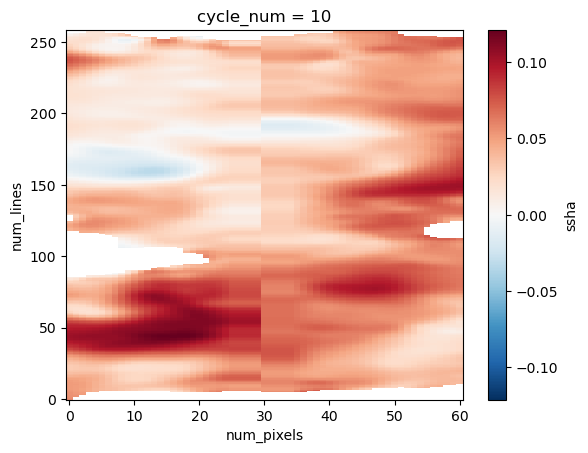

(<xarray.DataArray 'ssha' (cycle_num: 98, num_lines: 260, num_pixels: 61)> Size: 12MB
 dask.array<transpose, shape=(98, 260, 61), dtype=float64, chunksize=(98, 260, 61), chunktype=numpy.ndarray>
 Coordinates:
   * cycle_num   (cycle_num) int64 784B 0 1 2 3 4 5 6 7 ... 91 92 93 94 95 96 97
   * num_lines   (num_lines) int64 2kB 0 1 2 3 4 5 6 ... 254 255 256 257 258 259
   * num_pixels  (num_pixels) int64 488B 0 1 2 3 4 5 6 7 ... 54 55 56 57 58 59 60
     latitude    (num_lines, num_pixels) float64 127kB dask.array<chunksize=(260, 61), meta=np.ndarray>
     longitude   (num_lines, num_pixels) float64 127kB dask.array<chunksize=(260, 61), meta=np.ndarray>
     time        (num_lines, num_pixels) datetime64[ns] 127kB dask.array<chunksize=(260, 61), meta=np.ndarray>,
 <xarray.DataArray 'ssha' (cycle_num: 98, num_lines: 259, num_pixels: 53)> Size: 11MB
 dask.array<where, shape=(98, 259, 53), dtype=float64, chunksize=(98, 259, 53), chunktype=numpy.ndarray>
 Coordinates:
   * cycle_num   (cycl

In [10]:
fscale = 2
h_interp = xr.open_zarr(op.join(sdir,
                        '01-day-repeat/MedSea/Pass016/ssha_rawgrid_%02dpoints.zarr' 
                        % (fscale))
                       ).ssha.interp(cycle_num=np.arange(len(ds16.calval))
                                    )
h_interp.coords["num_pixels"] = ("num_pixels", range(len(h_interp.num_pixels)))
h_interp.coords["num_lines"] = ("num_lines", range(len(h_interp.num_lines)))
maskh = xr.DataArray(h_interp.to_masked_array().mask,
                     dims=h_interp.dims, coords=h_interp.coords
                    )
h_dropped = h_interp.where(~maskh, drop=True)

h_dropped.isel(cycle_num=10).plot(rasterized=True)
plt.show()
h_interp, h_dropped

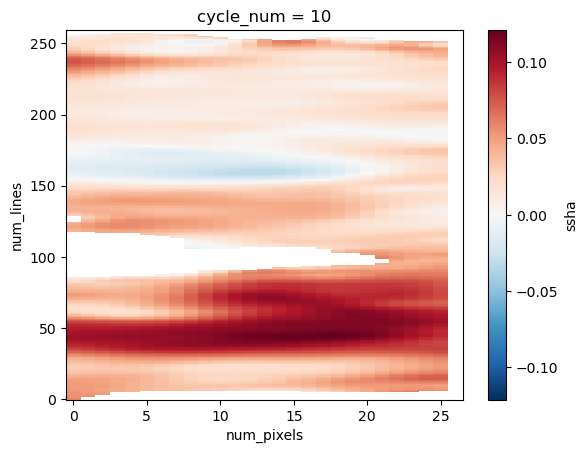

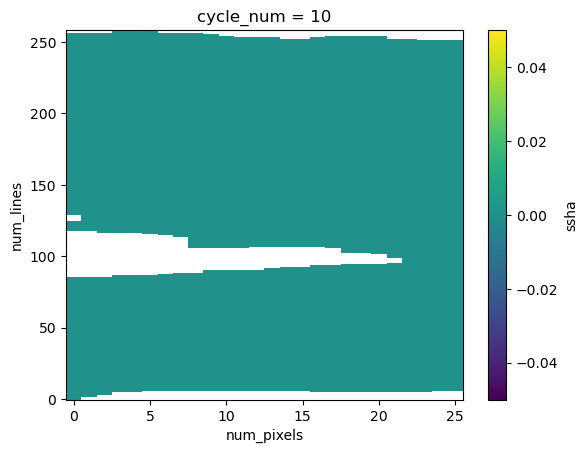

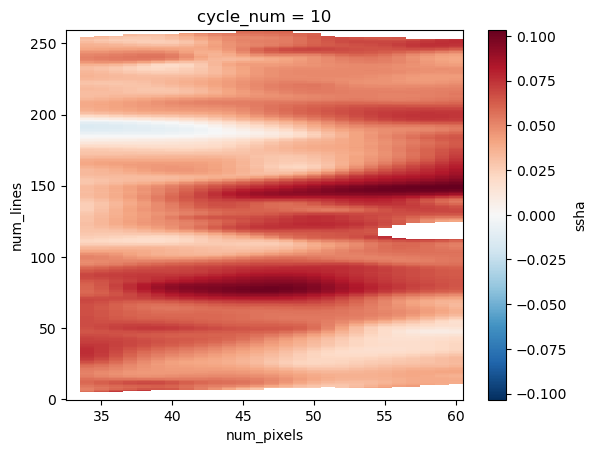

In [11]:
h_interp.isel(cycle_num=10,num_pixels=slice(None,27),num_lines=slice(None,None)).plot(rasterized=True)
plt.show()
(h_interp.isel(cycle_num=10,num_pixels=slice(None,26),num_lines=slice(None,None))
 - h_dropped.isel(cycle_num=10,num_pixels=slice(None,26))
).plot(rasterized=True)
plt.show()
h_interp.isel(cycle_num=10,num_pixels=slice(-28,None),num_lines=slice(None,None)).plot(rasterized=True)
plt.show()

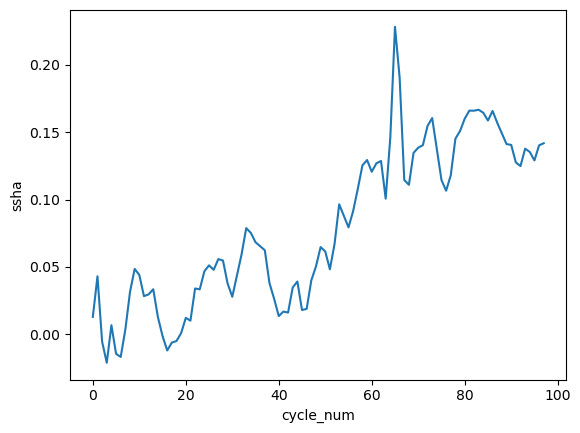

In [12]:
h_dropped.mean(['num_lines','num_pixels'],skipna=True).plot()

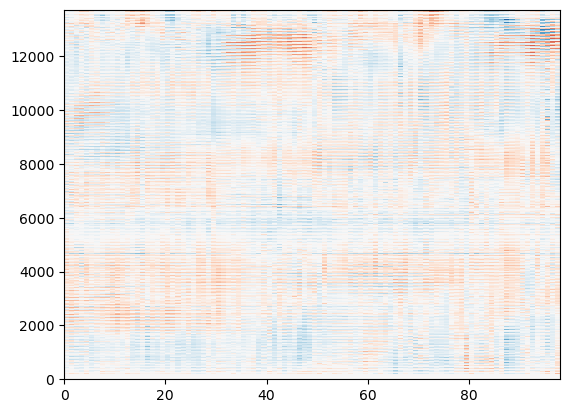

<xarray.DataArray 'ssha' (z: 13727, cycle_num: 98)> Size: 11MB
dask.array<transpose, shape=(13727, 98), dtype=float64, chunksize=(1750, 98), chunktype=numpy.ndarray>
Coordinates:
  * z           (z) object 110kB MultiIndex
  * cycle_num   (cycle_num) int64 784B 0 1 2 3 4 5 6 7 ... 91 92 93 94 95 96 97
    latitude    (z) float64 110kB dask.array<chunksize=(1750,), meta=np.ndarray>
    longitude   (z) float64 110kB dask.array<chunksize=(1750,), meta=np.ndarray>
    time        (z) datetime64[ns] 110kB dask.array<chunksize=(1750,), meta=np.ndarray>
  * num_lines   (z) int64 110kB 0 0 0 0 0 0 0 0 ... 258 258 258 258 258 258 258
  * num_pixels  (z) int64 110kB 0 1 2 3 4 5 6 7 8 ... 52 53 54 55 56 57 58 59 60

In [13]:
zchunk = 1750
h_stacked = (h_dropped 
             - h_dropped.mean(['num_lines','num_pixels'],skipna=True)
            ).stack(z=('num_lines','num_pixels')
                          ).chunk({'z':zchunk}).fillna(0.)
# h_stacked = h_interp.stack(z=("YC", "XC")
#                           ).chunk({'z':zchunk}).fillna(0.)

fig, ax = plt.subplots()
ax.pcolormesh(h_stacked.T.values, 
              rasterized=True,  
              vmax=.2, vmin=-.2, cmap='RdBu_r')
plt.show()
h_stacked.T

In [14]:
nh16 = ds16.time.astype('datetime64[s]').mean(["num_lines","num_pixels"]
                  ).diff("calval").mean().astype(np.float64).values
window_lengths = np.ceil( np.array([8, 9, 10, 30, 60])
                         * 86400/nh16 ).astype(int) # 24 hourly
step_sizes = np.array([1, 1, 1, 1, 1])
print(window_lengths, "[days]")
nh16 / 86400.

[ 8  9 10 29 57] [days]


1.0549537037037038

In [15]:
fit = False

In [18]:
# sr = 4
# svd_ranks = [sr] * len(window_lengths)
svd_ranks = [4, 4, 4, 10, 12]
if len(svd_ranks) != len(window_lengths):
    print("######### WRONG LENGTHS #########")
suppress_growth = True
transform_method = "absolute"
# n_components_array = [2] * len(window_lengths)
global_svd_array = [False] * len(window_lengths)
# kern_method = "flat"
# real_eig_limit = 0.5
# pydmd_kwargs = {
#     "eig_constraints": {"conjugate_pairs", "limited"},
#     "real_eig_limit": real_eig_limit,
# }

dmd = mrCOSTS(
    svd_rank_array=svd_ranks,
    window_length_array=window_lengths,
    step_size_array=step_sizes,
    global_svd_array=global_svd_array,
    cluster_sweep=True,
    transform_method=transform_method,
    # kern_method=kern_method,
    # relative_filter_length=relative_filter_length,
    # pydmd_kwargs=pydmd_kwargs,
)

if fit:
    dmd.fit(h_stacked.values.T, 
            np.atleast_2d(np.arange(len(h_stacked.cycle_num)
                                   ) * nh16)
           )

_________________________________________________
Fitting window length = 8
0 of 91
50 of 91
Error in Global Reconstruction = 0.25
_________________________________________________
Fitting window length = 9
0 of 90
50 of 90
Error in Global Reconstruction = 0.11
_________________________________________________
Fitting window length = 10
0 of 89
50 of 89
Error in Global Reconstruction = 0.074
_________________________________________________
Fitting window length = 29
0 of 70
50 of 70
Error in Global Reconstruction = 0.13
_________________________________________________
Fitting window length = 57
0 of 42
Error in Global Reconstruction = 0.15


In [16]:
if fit:
    # dmd.to_netcdf(op.join(ddir, 
    #                       "SWOT/CalVal/mrCOSTS_h/%02dhourly/%02d_fit"
    #                       % (nh,len(window_lengths))
    #                      )
    #              )
    dmd.to_netcdf(op.join(ddir, 
                  "SWOT/CalVal/mrCOSTS_h/MedSea/Pass%03d_%02d_raw_%02dpoints"
                  % (16,len(window_lengths),2)
                         )
                 )
else:
    mrc = glob.glob(op.join(ddir, 
                "SWOT/CalVal/mrCOSTS_h/MedSea/Pass%03d_05_raw_*.nc"
                % (16)
                           )
                   )
    print(mrc)
    dmd = mrCOSTS()
    dmd.from_netcdf(mrc)

['/tank/spectre/tuchida/DMD/SWOT/CalVal/mrCOSTS_h/MedSea/Pass016_05_raw_02points.window=10.nc', '/tank/spectre/tuchida/DMD/SWOT/CalVal/mrCOSTS_h/MedSea/Pass016_05_raw_02points.window=29.nc', '/tank/spectre/tuchida/DMD/SWOT/CalVal/mrCOSTS_h/MedSea/Pass016_05_raw_02points.window=9.nc', '/tank/spectre/tuchida/DMD/SWOT/CalVal/mrCOSTS_h/MedSea/Pass016_05_raw_02points.window=8.nc', '/tank/spectre/tuchida/DMD/SWOT/CalVal/mrCOSTS_h/MedSea/Pass016_05_raw_02points.window=57.nc']


# DMD outputs

In [17]:
dmd.multi_res_interp()
dmd._da_omega

<xarray.DataArray 'omega' (window_length: 5, window_time_means: 91, svd_rank: 12)> Size: 87kB
array([[[            nan           +nanj,
                     nan           +nanj,
         -7.62505977e-07+2.06671299e-05j, ...,
                     nan           +nanj,
                     nan           +nanj,
                     nan           +nanj],
        [            nan           +nanj,
                     nan           +nanj,
         -2.58575807e-06+2.75258313e-05j, ...,
                     nan           +nanj,
                     nan           +nanj,
                     nan           +nanj],
        [            nan           +nanj,
                     nan           +nanj,
         -4.69197959e-06+2.35465536e-05j, ...,
                     nan           +nanj,
                     nan           +nanj,
                     nan           +nanj],
        ...,
        [            nan           +nanj,
...
                     nan           +nanj],
        ...,
        [            nan           +nanj,
                     nan           +nanj,
                     nan           +nanj, ...,
                     nan           +nanj,
                     nan           +nanj,
                     nan           +nanj],
        [            nan           +nanj,
                     nan           +nanj,
                     nan           +nanj, ...,
                     nan           +nanj,
                     nan           +nanj,
                     nan           +nanj],
        [            nan           +nanj,
                     nan           +nanj,
                     nan           +nanj, ...,
                     nan           +nanj,
                     nan           +nanj,
                     nan           +nanj]]])
Coordinates:
  * window_length        (window_length) int64 40B 8 9 10 29 57
  * window_time_means    (window_time_means) float64 728B 3.19e+05 ... 8.522e+06
  * svd_rank             (svd_rank) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
    slide                (window_length, window_time_means) float64 4kB 0.0 ....
    decomposition_level  (window_length) int64 40B 0 1 2 3 4

fitting n_components = 4
fitting n_components = 5
fitting n_components = 6
fitting n_components = 7
fitting n_components = 8
fitting n_components = 9
fitting n_components = 10
fitting n_components = 11
fitting n_components = 12
fitting n_components = 13
fitting n_components = 14
fitting n_components = 15
fitting n_components = 16
fitting n_components = 17
fitting n_components = 18
fitting n_components = 19
fitting n_components = 20
fitting n_components = 21
fitting n_components = 22
fitting n_components = 23
fitting n_components = 24
fitting n_components = 25
fitting n_components = 26
fitting n_components = 27
fitting n_components = 28
fitting n_components = 29
Optimal silhouette score is = 18


Text(0, 0.5, 'Silhouette score (-), (1 is best, -1 is worst)')

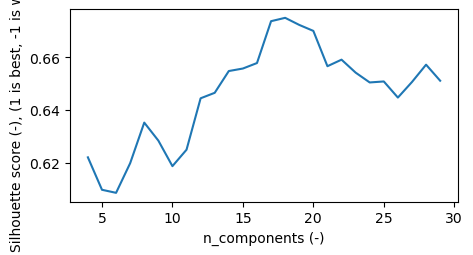

In [18]:
n_components_range = np.arange(4, 30)
scores, n3_optimal = dmd.global_cluster_hyperparameter_sweep(
    n_components_range,
    transform_method="log10",
)

print("Optimal silhouette score is = {}".format(n3_optimal))
plt.figure(figsize=(5, 2.5))
plt.plot(n_components_range, scores)
plt.gca().set_xlabel("n_components (-)")
plt.gca().set_ylabel("Silhouette score (-), (1 is best, -1 is worst)")

In [19]:
# n_ops = 10
cluster_centroids16, omega_classes, omega_array = dmd.global_cluster_omega(
    n3_optimal,
    # n_ops,
    transform_method="log10"
)
cluster_centers_periods16 = 1 / (10 ** (cluster_centroids16) / (2 * np.pi))

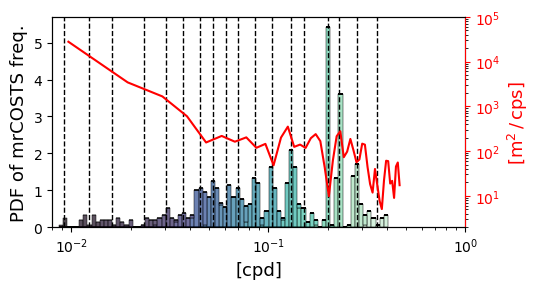

In [20]:
x_trans = (2 * np.pi / 10**omega_array / 86400.)**-1
# unique_labels, label_counts = np.unique(omega_classes, return_counts=True)
# weights = label_counts.max() / label_counts
# x_trans_labels = [x_trans[omega_classes == label] for label in unique_labels]

# weights_labels = []
# unique_labels = unique_labels.astype(int)
# for label in unique_labels:
#     ind_array = np.flatnonzero(unique_labels == label)
#     ind_list = int(ind_array)
#     w = weights[ind_array]
#     x_w = x_trans_labels[ind_list]
#     w_broadcast = np.broadcast_to(w, (x_w.shape))
#     weights_labels.append(w_broadcast)
hue_order = np.arange(len(np.unique(omega_classes))).astype(str)
cluster_centers16 = 1 / ((10 ** cluster_centroids16) / (2 * np.pi) / 86400.)

# Make a continuous color palette with the brightest and darkest excluded
palette = sns.color_palette("mako", len(cluster_centers16) + 2)
# palette = palette[1:-1]


Fh = xrft.power_spectrum(h_dropped[...,::150,10::40
                         ].chunk({'cycle_num':-1}
                                ).assign_coords({'cycle_num':
                                                 np.arange(len(h_interp.cycle_num)) 
                                                 * nh16}
                                               ), 
                         dim='cycle_num', window='hann', window_correction=True
                        ).astype(np.single)

from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(figsize=(5.5, 3))
ax2 = ax.twinx()
fig.set_tight_layout(True)

ax2.plot(Fh.freq_cycle_num.isel(freq_cycle_num=slice(len(Fh.freq_cycle_num)//2+1,None)
                               )*86400, 
         Fh.isel(freq_cycle_num=slice(len(Fh.freq_cycle_num)//2+1,None)
                ).mean(['num_pixels','num_lines'],skipna=True)*2,
         c='r', label=r"Fourier")

# ax = plt.gca()
ax.set_xscale("log")
# ax2.set_xscale("log")
ax2.set_yscale("log")
# ax.set_title(
#     "Global histogram of frequencies; Interpolated decomposition levels"
# )
# ax.set_xlabel(r"Period; $(2 \pi) / Im(|\omega|)$ [day]")

# ax.hist(
#     x=x_trans_labels,
#     bins=np.logspace(stop=np.log10((1.9e4/86400)**-1), 
#                      start=np.log10((1.5e6/86400)**-1), 
#                      num=200),
#     histtype="barstacked",
#     weights=weights_labels,
#     # alpha=.8,
# )
sns.histplot(
    # x=((10**omega_array) / (2 * np.pi) / 86400.),
    x=x_trans,
    hue=omega_classes,
    hue_order=hue_order,
    common_bins=True,
    common_norm=True,
    stat="density",
    multiple="stack",
    bins=80,
    palette=ListedColormap(palette),
    legend=False,
    ax=ax
)

ax.set_xlabel(r"[cpd]", fontsize=13)
ax.set_ylabel("PDF of mrCOSTS freq.", fontsize=13)
ax2.set_ylabel("[m$^2\,/\,$cps]", fontsize=13, c='r')

ax.set_xlim([8e-3,1e0])
# ax2.set_xlim([8e-3,1.5e1])
ax2.set_ylim([2e0,1e5])

# ax2.fill_between(np.array([1/(24.*2*3600.)*86400, 1/(24.*3600.)*86400]), 
#                  2e1, 1e5, 
#                  color='r', alpha=.15)
ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', colors='red')

[
    ax.axvline((2 * np.pi / (10**c) / 86400)**-1, color="k", ls="--", lw=1)
    for nc, c in enumerate(cluster_centroids16)
];
# ylim_bottom, ylim_top = ax.get_ylim()
# [
#     ax.text(
#         2 * np.pi / (10**c),
#         ylim_top - ylim_top * 0.1,
#         "{:4.0f}d".format(1 / (10 ** (c) / (2 * np.pi))),
#         rotation="vertical",
#         va="top",
#         ha="right",
#     )
#     for c in cluster_centroids
# ];

# y_lim_bottom, y_lim_top = ax.get_ylim()
# [
#     ax.text(
#         c,
#         y_lim_top - y_lim_top * 0.2,
#         # "{:0.2f} Hz".format(c),
#         rotation="vertical",
#         va="top",
#         ha="right",
#     )
#     for c in cluster_centers
# ];
plt.savefig(op.join(sdir,'Figs/SWOT-MedSea_Pass016_mrCOSTS_hist-%02d_%02dpoints.pdf' 
                    % (len(window_lengths),fscale))
           )

In [21]:
np.where((2 * np.pi / (10**cluster_centroids16) 
          / 86400)**-1 < 1e-1)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),)

In [24]:
omega_classes_list = dmd.multi_res_deterp()

(13727, 98) <xarray.DataArray 'ssha' (cycle_num: 98, z: 13727)> Size: 11MB
dask.array<where, shape=(98, 13727), dtype=float64, chunksize=(98, 1750), chunktype=numpy.ndarray>
Coordinates:
  * cycle_num   (cycle_num) int64 784B 0 1 2 3 4 5 6 7 ... 91 92 93 94 95 96 97
  * z           (z) object 110kB MultiIndex
    latitude    (z) float64 110kB dask.array<chunksize=(1750,), meta=np.ndarray>
    longitude   (z) float64 110kB dask.array<chunksize=(1750,), meta=np.ndarray>
    time        (z) datetime64[ns] 110kB dask.array<chunksize=(1750,), meta=np.ndarray>
  * num_lines   (z) int64 110kB 0 0 0 0 0 0 0 0 ... 258 258 258 258 258 258 258
  * num_pixels  (z) int64 110kB 0 1 2 3 4 5 6 7 8 ... 52 53 54 55 56 57 58 59 60


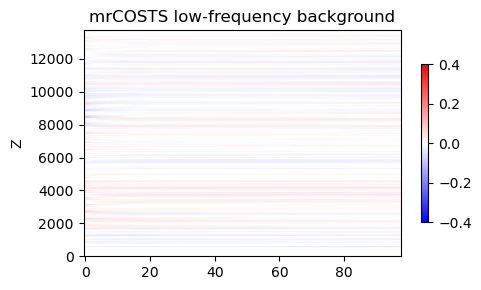

In [25]:
xr_background = dmd.get_background()
print(xr_background.shape, h_stacked)

bg_unstacked = xr.DataArray(xr_background, dims=h_stacked.T.dims,
                            coords=h_stacked.T.coords
                           ).unstack().chunk({'cycle_num':1})
ds_global_background = h_interp.copy()
# ds_global_background.loc[dict(num_lines=background_unstacked.num_lines, 
#                               num_pixels=background_unstacked.num_pixels)
# ] = background_unstacked
ds_global_background[dict(num_pixels=slice(None,26),
                          num_lines=slice(None,-1))
] = bg_unstacked[dict(num_pixels=slice(None,26))]
ds_global_background[dict(num_pixels=slice(-27,None),
                          num_lines=slice(None,-1))
] = bg_unstacked[dict(num_pixels=slice(-27,None))]
ds_global_background.where(mm16.isel(num_pixels=slice(npx,-npx),
                                    num_lines=slice(nln,-nln)
                                   )!=1).chunk(
        {'num_pixels':-1, 'num_lines':-1}
).to_dataset(name='background'
            ).to_zarr(op.join(ddir,
            'SWOT/CalVal/mrCOSTS_h/MedSea/Pass%03d/background-raw_%02dpoints.zarr' 
                              % (16, fscale)),
                              mode='w')

fig, ax = plt.subplots(figsize=(5, 3))
fig.set_tight_layout(True)
im = ax.pcolormesh(
    h_stacked.cycle_num,
    np.arange(len(h_stacked.z)), 
    xr_background, 
    vmin=-.4, vmax=.4, cmap="bwr",
    rasterized=True
)
ax.set_title("mrCOSTS low-frequency background")
ax.set_ylabel("Z")
# fig.autofmt_xdate()
fig.colorbar(im, shrink=.7)

In [26]:
xr_sep = dmd.global_scale_reconstruction()

In [65]:
(dmd.n_decompositions, 
 (dmd.ragged_omega_classes[0]>-1).shape, 
 dmd.ragged_amplitudes_array[0].shape)

(5, (91, 12), (91, 4))

In [27]:
for ncl_center, cl_center in enumerate(cluster_centers_periods16):
    
    ds_xr_sep = xr.DataArray(
        xr_sep.real[:, ncl_center],
        dims=["decomp_level", "z", "cycle_num"],
        coords=[
            np.arange(len(dmd.costs_array)),
            # np.arange(n_optimal),
            h_stacked.z,
            h_stacked.cycle_num,
        ],
    )
    
    for dd in ds_xr_sep.decomp_level:
        if dd == 0:
            ds_global_separation = h_interp.copy()
            sep_unstacked = ds_xr_sep.sel(decomp_level=dd
                                 ).unstack().chunk({'cycle_num':1})
            ds_global_separation[dict(num_pixels=slice(None,26),
                                      num_lines=slice(None,-1))
            ] = sep_unstacked[dict(num_pixels=slice(None,26))]
            ds_global_separation[dict(num_pixels=slice(-27,None),
                                      num_lines=slice(None,-1))
            ] = sep_unstacked[dict(num_pixels=slice(-27,None))]
        else:
            tmp = h_interp.copy()
            sep_unstacked = ds_xr_sep.sel(decomp_level=dd
                                 ).unstack().chunk({'cycle_num':1})
            tmp[dict(num_pixels=slice(None,26),
                                      num_lines=slice(None,-1))
            ] = sep_unstacked[dict(num_pixels=slice(None,26))]
            tmp[dict(num_pixels=slice(-27,None),
                                      num_lines=slice(None,-1))
            ] = sep_unstacked[dict(num_pixels=slice(-27,None))]
            ds_global_separation = xr.concat([ds_global_separation,
                                              tmp
                                             ], 'decomp_level'
                                            )
            del tmp

    ds_global_separation = ds_global_separation.where(mm16.isel(num_pixels=slice(npx,-npx),
                                                               num_lines=slice(nln,-nln)
                                                              )!=1).chunk({'cycle_num':1})
    # ds_xr_sep.isel(decomp_level=0).sum("cluster").plot(rasterized=True)
    ds_cluster_centers = xr.DataArray(
        np.array([1 / (10 ** (cluster_centroids16[ncl_center]) / (2 * np.pi)),]),
        dims=["cluster"],
        # coords=[np.arange(n_optimal)],
        coords=[np.array([ncl_center,])],
    )
    ds_cluster_centers.attrs["units"] = "s"
    ds_cluster_centers.attrs["long_name"] = "Central period of each period band"
    
    ds_global_separation = ds_global_separation.to_dataset(name="frequency_bands")
    ds_global_separation["frequency_bands"].attrs["units"] = "m"
    ds_global_separation["frequency_bands"].attrs["long_name"] = "mrCOSTS"
    
    ds_global_separation.coords["cluster_centers"] = ds_cluster_centers

    if ncl_center == 0:
        print(ds_global_separation)
        
    ds_global_separation.chunk(
                {'num_pixels':-1, 'num_lines':-1}
                ).to_zarr(op.join(ddir,
    'SWOT/CalVal/mrCOSTS_h/MedSea/Pass%03d/cluster%02d-raw_%02dpoints.zarr' 
                      % (16, ncl_center, fscale)),
                      mode='w')
    print(ncl_center)

<xarray.Dataset> Size: 63MB
Dimensions:          (num_lines: 260, num_pixels: 61, cycle_num: 98,
                      decomp_level: 5, cluster: 1)
Coordinates:
  * num_lines        (num_lines) int64 2kB 0 1 2 3 4 5 ... 255 256 257 258 259
  * num_pixels       (num_pixels) int64 488B 0 1 2 3 4 5 6 ... 55 56 57 58 59 60
  * cycle_num        (cycle_num) int64 784B 0 1 2 3 4 5 6 ... 92 93 94 95 96 97
  * cluster          (cluster) int64 8B 0
    latitude         (num_lines, num_pixels) float64 127kB dask.array<chunksize=(260, 61), meta=np.ndarray>
    longitude        (num_lines, num_pixels) float64 127kB dask.array<chunksize=(260, 61), meta=np.ndarray>
    time             (num_lines, num_pixels) datetime64[ns] 127kB dask.array<chunksize=(260, 61), meta=np.ndarray>
    cluster_centers  (cluster) float64 8B 9.437e+06
Dimensions without coordinates: decomp_level
Data variables:
    frequency_bands  (decomp_level, cycle_num, num_lines, num_pixels) float64 62MB dask.array<chunksize=(1, 1, 26

In [28]:
xr_global_reconstruction = dmd.global_reconstruction()
glb_unstacked = xr.DataArray(
    data=xr_global_reconstruction.real, 
    dims=h_stacked.T.dims,
    coords=h_stacked.T.coords
).unstack()
da_global_reconstruction = h_interp.copy()
da_global_reconstruction[dict(num_pixels=slice(None,26),
                          num_lines=slice(None,-1))
] = glb_unstacked[dict(num_pixels=slice(None,26))]
da_global_reconstruction[dict(num_pixels=slice(-27,None),
                          num_lines=slice(None,-1))
] = glb_unstacked[dict(num_pixels=slice(-27,None))]
da_global_reconstruction = da_global_reconstruction.where(mm16.isel(num_pixels=slice(npx,-npx),
                                                                   num_lines=slice(nln,-nln)
                                                                  )!=1).chunk({'cycle_num':1,
                                                           'num_pixels':-1, 'num_lines':-1})
da_global_reconstruction.attrs["units"] = "m"
da_global_reconstruction.attrs["long_name"] = r"SWOT SSH"

da_global_reconstruction.chunk(
    # {'lat':100, 'lon':100}
).to_dataset(name='SSH').to_zarr(op.join(ddir,
                    'SWOT/CalVal/mrCOSTS_h/MedSea/Pass%03d/Total-raw_%02dpoints.zarr' 
                      % (16, fscale)),
                      mode='w')

# Extract slow component

In [22]:
fscale = 2
for i in range(30):
    if i == 0:
        dsc16 = xr.open_zarr(op.join(ddir,
            'SWOT/CalVal/mrCOSTS_h/MedSea/Pass016/cluster%02d-raw_%02dpoints.zarr' 
                           % (i,fscale))
                          )

    else:
        try:
            dsc16 = xr.concat([dsc16,xr.open_zarr(op.join(ddir,
                    'SWOT/CalVal/mrCOSTS_h/MedSea/Pass016/cluster%02d-raw_%02dpoints.zarr' 
                                   % (i,fscale)))
                                ], 'cluster')

        except:
            pass
    
dsC16 = xr.open_zarr(op.join(ddir,
            'SWOT/CalVal/mrCOSTS_h/MedSea/Pass016/Total-raw_%02dpoints.zarr' 
                           % (fscale))
                  )

dsb16 = xr.open_zarr(op.join(ddir,
            'SWOT/CalVal/mrCOSTS_h/MedSea/Pass016/background-raw_%02dpoints.zarr' 
                           % (fscale))
                  )

dsc16

<xarray.Dataset> Size: 1GB
Dimensions:          (cluster: 18, decomp_level: 5, cycle_num: 98,
                      num_lines: 260, num_pixels: 61)
Coordinates:
  * cluster          (cluster) int64 144B 0 1 2 3 4 5 6 ... 11 12 13 14 15 16 17
  * cycle_num        (cycle_num) int64 784B 0 1 2 3 4 5 6 ... 92 93 94 95 96 97
  * num_lines        (num_lines) int64 2kB 0 1 2 3 4 5 ... 255 256 257 258 259
  * num_pixels       (num_pixels) int64 488B 0 1 2 3 4 5 6 ... 55 56 57 58 59 60
    cluster_centers  (cluster) float64 144B dask.array<chunksize=(1,), meta=np.ndarray>
    latitude         (num_lines, num_pixels) float64 127kB 41.37 41.36 ... 36.58
    longitude        (num_lines, num_pixels) float64 127kB 2.272 2.248 ... 2.257
    time             (num_lines, num_pixels) datetime64[ns] 127kB 2023-03-29T...
Dimensions without coordinates: decomp_level
Data variables:
    frequency_bands  (cluster, decomp_level, cycle_num, num_lines, num_pixels) float64 1GB dask.array<chunksize=(1, 1, 1, 260, 61), meta=np.ndarray>

In [23]:
ds16_gridded = xr.open_zarr(op.join(sdir,
                            '01-day-repeat/MedSea/Pass016/raw-gridded_linear.zarr')
                   )

ds16_gridded.coords["cycle_num"] = H16_interp.cycle_num

ds16d = xr.open_zarr(op.join(sdir,
                     '01-day-repeat/MedSea/Pass%03d.zarr' 
                     % 16)
                  ).isel(num_lines=slice(109+iln,370-iln),
                         num_pixels=slice(3+ipx,-3-ipx)
                        )

ds16d.coords["calval"] = range(98)
ds16d

<xarray.Dataset> Size: 23MB
Dimensions:    (calval: 98, num_lines: 257, num_pixels: 57)
Coordinates:
  * calval     (calval) int64 784B 0 1 2 3 4 5 6 7 8 ... 90 91 92 93 94 95 96 97
    latitude   (num_lines, num_pixels) float64 117kB dask.array<chunksize=(257, 57), meta=np.ndarray>
    longitude  (num_lines, num_pixels) float64 117kB dask.array<chunksize=(257, 57), meta=np.ndarray>
    time       (calval, num_lines, num_pixels) datetime64[ns] 11MB dask.array<chunksize=(25, 91, 29), meta=np.ndarray>
Dimensions without coordinates: num_lines, num_pixels
Data variables:
    ssha_v3    (calval, num_lines, num_pixels) float64 11MB dask.array<chunksize=(25, 91, 29), meta=np.ndarray>

## Vorticity-strain

In [24]:
n_cluster16 = len(np.where((2 * np.pi / (10**cluster_centroids16) 
                          / 86400)**-1 <= 2e-1)[0])
print(n_cluster16)
low16 = (dsb16.background 
       + dsc16.frequency_bands.isel(cluster=slice(None,n_cluster16)
                                 ).sum(['cluster','decomp_level'])
      )
# array = xr.open_zarr(sdir,
#                      '01-day-repeat/GulfStream/ssha_linear_%02dkm.zarr' 
#                      % (fscale)
#                     ).ssha.isel(num_pixels=slice(nph,-nph),
#                                 num_lines=slice(nlh,-nlh)
#                                ).to_masked_array()
# mask_low = xr.DataArray(~array.mask, dims=low.dims,
#                         coords=low.coords
#                        )
# low = low.where(mask_low)

tot = xr.open_zarr(op.join(ddir,
                   'SWOT/CalVal/mrCOSTS_h/MedSea/Pass016/Total-raw_%02dpoints.zarr' 
                   % (fscale))
                  ).SSH
# tot = tot.where(mask_low)
low16

14


<xarray.DataArray (cycle_num: 98, num_lines: 260, num_pixels: 61)> Size: 12MB
dask.array<add, shape=(98, 260, 61), dtype=float64, chunksize=(1, 260, 61), chunktype=numpy.ndarray>
Coordinates:
  * cycle_num   (cycle_num) int64 784B 0 1 2 3 4 5 6 7 ... 91 92 93 94 95 96 97
  * num_lines   (num_lines) int64 2kB 0 1 2 3 4 5 6 ... 254 255 256 257 258 259
  * num_pixels  (num_pixels) int64 488B 0 1 2 3 4 5 6 7 ... 54 55 56 57 58 59 60
    latitude    (num_lines, num_pixels) float64 127kB 41.37 41.36 ... 36.58
    longitude   (num_lines, num_pixels) float64 127kB 2.272 2.248 ... 2.257
    time        (num_lines, num_pixels) datetime64[ns] 127kB 2023-03-29T11:02...

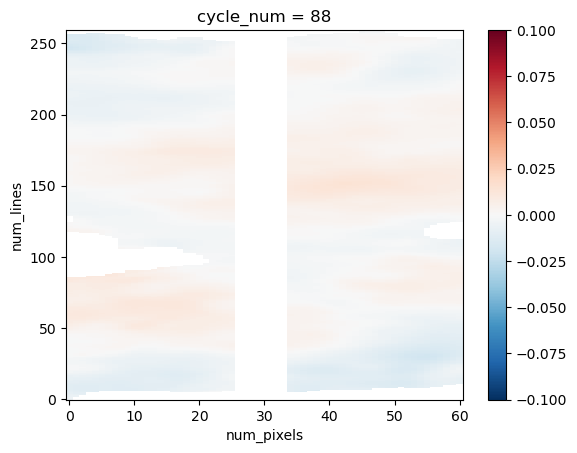

In [25]:
(tot-low16).isel(cycle_num=-10).plot(vmax=1e-1)

<xarray.DataArray (cycle_num: 93, YC: 272, XC: 116)> Size: 23MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, 

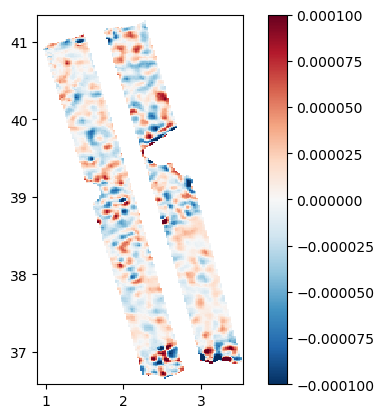

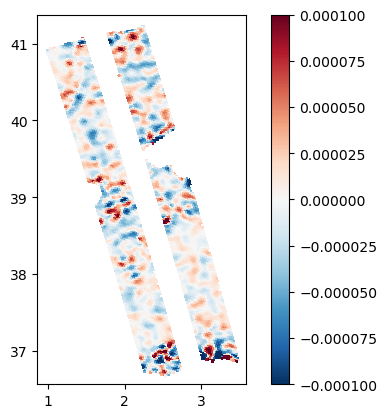

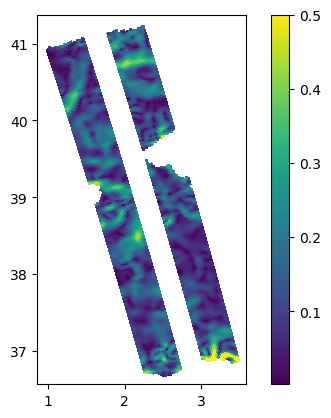

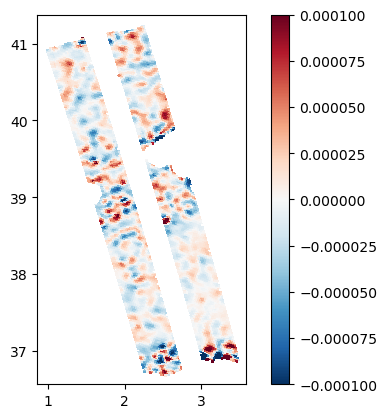

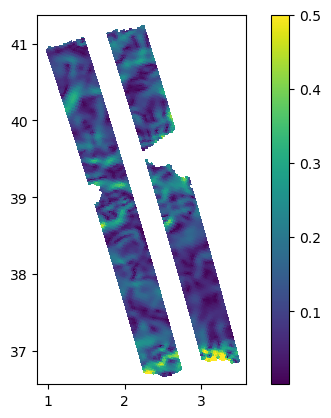

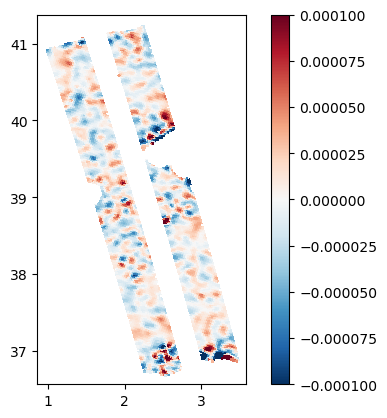

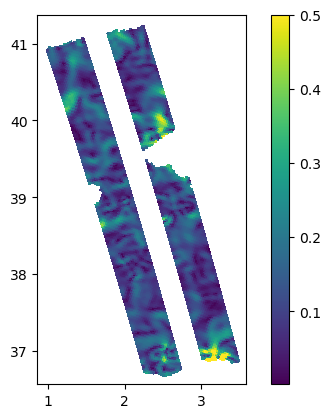

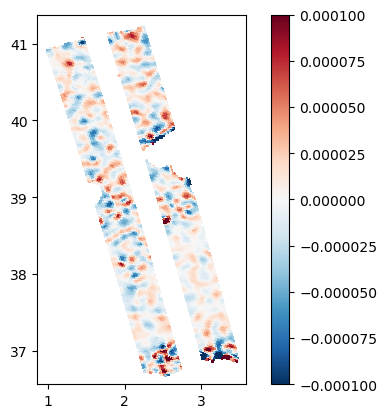

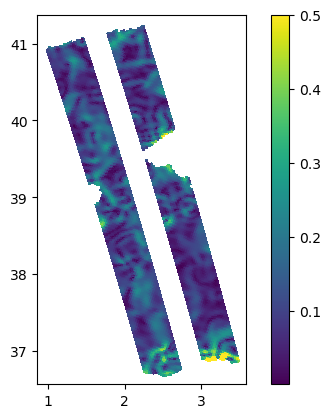

<xarray.Dataset> Size: 71MB
Dimensions:     (num_lines: 260, num_pixels: 61, cycle_num: 93)
Coordinates:
  * num_lines   (num_lines) int64 2kB 0 1 2 3 4 5 6 ... 254 255 256 257 258 259
  * num_pixels  (num_pixels) int64 488B 0 1 2 3 4 5 6 7 ... 54 55 56 57 58 59 60
  * cycle_num   (cycle_num) int64 744B 0 1 2 3 4 5 6 7 ... 91 92 93 94 95 96 97
    latitude    (num_lines, num_pixels) float64 127kB 41.37 41.36 ... 36.58
    longitude   (num_lines, num_pixels) float64 127kB 2.272 2.248 ... 2.257
    time        (cycle_num, num_lines, num_pixels) datetime64[ns] 12MB dask.array<chunksize=(2, 93, 31), meta=np.ndarray>
Data variables:
    vort        (cycle_num, num_lines, num_pixels) float64 12MB nan nan ... nan
    strain      (cycle_num, num_lines, num_pixels) float64 12MB nan nan ... nan
    vg          (cycle_num, num_lines, num_pixels) float64 12MB nan nan ... nan
    ug          (cycle_num, num_lines, num_pixels) float64 12MB nan nan ... nan
    ssha        (cycle_num, num_lines, num_p

In [26]:
yy, xx = np.mgrid[low16.latitude.min(skipna=True).values:low16.latitude.max(skipna=True).values:np.abs(low16.latitude.diff('num_lines').min(skipna=True).values),
                  low16.longitude.min(skipna=True).values:low16.longitude.max(skipna=True).values:np.abs(low16.longitude.diff('num_pixels').min(skipna=True).values)
                 ]
lon = griddata((low16.latitude.values.flatten(),
                low16.longitude.values.flatten()
               ), 
               low16.longitude.values.flatten(), 
               (yy, xx), method='linear'
              )
lat = griddata((low16.latitude.values.flatten(),
                low16.longitude.values.flatten()
               ), 
               low16.latitude.values.flatten(), 
               (yy, xx), method='linear'
              )
for cc in ds16_gridded.cycle_num:
    ssh = griddata((low16.latitude.values.flatten(),
                    low16.longitude.values.flatten()
                   ), 
                   low16.sel(cycle_num=cc).values.flatten(), 
                   (yy, xx), method=meth
                  )
    if cc == ds16_gridded.cycle_num[0]:
        low16_gridded = xr.DataArray(ssh, dims=['YC','XC'], 
                           coords={'YC':np.mean(yy, axis=1),
                                   'XC':np.mean(xx, axis=0)}
                          )
    else:
        low16_gridded = xr.concat([low16_gridded, 
                          xr.DataArray(ssh, dims=['YC','XC'], 
                           coords={'YC':np.mean(yy, axis=1),
                                   'XC':np.mean(xx, axis=0)}
                          )
                         ], "cycle_num")
    del ssh
low16_gridded.coords['cycle_num'] = ds16_gridded.cycle_num
print(low16_gridded)
####################
xx, yy = np.meshgrid(low16_gridded.XC, low16_gridded.YC)
dx = gsw.distance(xx, yy, p=0, axis=-1)
dy = gsw.distance(xx, yy, p=0, axis=0)

cori = gsw.f(low16_gridded.YC)
coriY = gsw.f(low16_gridded.YC.rolling(YC=2).mean().dropna("YC"))

u = -(grav * low16_gridded.diff("YC")
      / coriY
      / dy)
v = (grav * low16_gridded.diff("XC")
     / cori 
     / dx)

u_x = u.diff("XC").values / (.5*(dx[1:] + dx[:-1]))
v_y = v.diff("YC").values / (.5*(dy[:,1:] + dy[:,:-1]))
u_x = .25*(u_x[...,:-1,:-1] + u_x[...,1:,:-1] + u_x[...,1:,1:] + u_x[...,:-1,1:])
v_y = .25*(v_y[...,:-1,:-1] + v_y[...,1:,:-1] + v_y[...,1:,1:] + v_y[...,:-1,1:])

u_y = (u.diff("YC").values / (.5*(dy[1:] + dy[:-1])))[...,:,1:-1]
v_x = (v.diff("XC").values / (.5*(dx[:,1:] + dx[:,:-1])))[:,1:-1]
        
vort = v_x - u_y

sn = u_x - v_y
ss = v_x + u_y
strain = np.sqrt(sn**2 + ss**2)

YG = (.5*(low16_gridded.YC[1:].data + low16_gridded.YC[:-1].data))
XG = (.5*(low16_gridded.XC[1:].data + low16_gridded.XC[:-1].data))

vor_g = xr.DataArray(vort, dims=["cycle_num",'YF','XF'], 
                     coords={"cycle_num":ds16_gridded.cycle_num.data,
                             'YF':low16_gridded.YC[1:-1].data, 
                             'XF':low16_gridded.XC[1:-1].data}
                    )
str_g = xr.DataArray(strain, dims=["cycle_num",'YF','XF'], 
                     coords={"cycle_num":ds16_gridded.cycle_num.data,
                             'YF':low16_gridded.YC[1:-1].data, 
                             'XF':low16_gridded.XC[1:-1].data}
                    )
u_g = xr.DataArray(u.data, dims=["cycle_num",'YG','XC'], 
                   coords={"cycle_num":ds16_gridded.cycle_num.data,
                           'YG':YG,
                           'XC':low16_gridded.XC.data}
                  )
v_g = xr.DataArray(v.data, dims=["cycle_num",'YC','XG'], 
                   coords={"cycle_num":ds16_gridded.cycle_num.data,
                           'YC':low16_gridded.YC.data,
                           'XG':XG}
                  )
                                             
fig, ax = plt.subplots()
im = ax.pcolormesh(low16_gridded.XC[1:-1].data, 
                   low16_gridded.YC[1:-1].data,
                   vor_g.isel(cycle_num=10),
                   rasterized=True,
                   cmap='RdBu_r', vmin=-1e-4, vmax=1e-4,
                  )
ax.set_aspect('equal')
fig.colorbar(im)
plt.show()

xf, yf = np.meshgrid(low16_gridded.XC[1:-1].data, 
                     low16_gridded.YC[1:-1].data)
xg, yc = np.meshgrid(XG, low16_gridded.YC.data)
xc, yg = np.meshgrid(low16_gridded.XC.data, YG)

for ii in ds16_gridded.cycle_num:
    
    _vorg = griddata((yf.flatten(), xf.flatten()), 
                   vor_g.sel(cycle_num=ii).values.flatten(), 
                   (low16.latitude.values,
                    low16.longitude.values), 
                   method=meth
                  )
    _strg = griddata((yf.flatten(), xf.flatten()), 
                   str_g.sel(cycle_num=ii).values.flatten(), 
                   (low16.latitude.values,
                    low16.longitude.values), 
                   method=meth
                  )
    
    _vg = griddata((yc.flatten(), xg.flatten()), 
                   v_g.sel(cycle_num=ii).values.flatten(), 
                   (low16.latitude.values,
                    low16.longitude.values), 
                   method=meth
                  )
    
    _ug = griddata((yg.flatten(), xc.flatten()), 
                   u_g.sel(cycle_num=ii).values.flatten(), 
                   (low16.latitude.values,
                    low16.longitude.values), 
                   method=meth
                  )

    maskh = low16.sel(cycle_num=ii).isel(num_pixels=slice(None,None)
                                    ).to_masked_array().mask
    array = np.ma.masked_array(_vorg)
    # get only the valid values
    y1 = low16.latitude.values[~array.mask][0]
    x1 = low16.longitude.values[~array.mask][0]
    newarr = array[~array.mask][0]
    _vort = xr.DataArray(griddata((y1.flatten(),x1.flatten()),
                                 newarr.flatten(), 
                                 (low16.latitude.isel(num_pixels=slice(None,None)
                                            ).values,
                                  low16.longitude.isel(num_pixels=slice(None,None)
                                            ).values), 
                                 method=meth,
                                           # fill_value=0.
                                ), 
                        dims=low16.sel(cycle_num=ii).isel(num_pixels=slice(None,None)
                                            ).dims,
                        coords=low16.sel(cycle_num=ii).isel(num_pixels=slice(None,None)
                                            ).coords
                       ).where(~maskh)
    array = np.ma.masked_array(_strg)
    # get only the valid values
    y1 = low16.latitude.values[~array.mask][0]
    x1 = low16.longitude.values[~array.mask][0]
    newarr = array[~array.mask][0]
    _strain = xr.DataArray(griddata((y1.flatten(),x1.flatten()),
                                 newarr.flatten(), 
                                 (low16.latitude.isel(num_pixels=slice(None,None)
                                            ).values,
                                  low16.longitude.isel(num_pixels=slice(None,None)
                                            ).values), 
                                 method=meth,
                                           # fill_value=0.
                                ), 
                        dims=low16.sel(cycle_num=ii).isel(num_pixels=slice(None,None)
                                            ).dims,
                        coords=low16.sel(cycle_num=ii).isel(num_pixels=slice(None,None)
                                            ).coords
                       ).where(~maskh)
    array = np.ma.masked_array(_ug)
    # get only the valid values
    y1 = low16.latitude.values[~array.mask][0]
    x1 = low16.longitude.values[~array.mask][0]
    newarr = array[~array.mask][0]
    _ug = xr.DataArray(griddata((y1.flatten(),x1.flatten()),
                                 newarr.flatten(), 
                                 (low16.latitude.isel(num_pixels=slice(None,None)
                                            ).values,
                                  low16.longitude.isel(num_pixels=slice(None,None)
                                            ).values), 
                                 method=meth,
                                           # fill_value=0.
                                ), 
                        dims=low16.sel(cycle_num=ii).isel(num_pixels=slice(None,None)
                                            ).dims,
                        coords=low16.sel(cycle_num=ii).isel(num_pixels=slice(None,None)
                                            ).coords
                       ).where(~maskh)
    array = np.ma.masked_array(_vg)
    # get only the valid values
    y1 = low16.latitude.values[~array.mask][0]
    x1 = low16.longitude.values[~array.mask][0]
    newarr = array[~array.mask][0]
    _vg = xr.DataArray(griddata((y1.flatten(),x1.flatten()),
                                 newarr.flatten(), 
                                 (low16.latitude.isel(num_pixels=slice(None,None)
                                            ).values,
                                  low16.longitude.isel(num_pixels=slice(None,None)
                                            ).values), 
                                 method=meth,
                                           # fill_value=0.
                                ), 
                        dims=low16.sel(cycle_num=ii).isel(num_pixels=slice(None,None)
                                            ).dims,
                        coords=low16.sel(cycle_num=ii).isel(num_pixels=slice(None,None)
                                            ).coords
                       ).where(~maskh)

    # dsuv = _ug.to_dataset(name="ug").swap_dims({'num_pixels':'x', 'num_lines':'y'}
    #                                           ).reset_coords(drop=True)
    # dsuv["vg"] = _vg.swap_dims({'num_pixels':'x', 'num_lines':'y'}
    #                           ).reset_coords(drop=True)
    # dsuv.coords["y"] = ("y",range(len(dsuv.y)))
    # dsuv.coords["x"] = ("x",range(len(dsuv.x)))
    # if not dsuv.rio.crs:
    #     dsuv = dsuv.rio.write_crs("EPSG:4326")
    #     # dsH3 = dsH3.rio.write_crs("EPSG:3857")
    # if dsuv.ug.rio.nodata is None:
    #     dsuv["ug"] = dsuv.ug.rio.write_nodata(np.nan)
    # if dsuv.vg.rio.nodata is None:
    #     dsuv["vg"] = dsuv.vg.rio.write_nodata(np.nan)
    # _ug_extrap = dsuv.rio.interpolate_na().swap_dims({'x':'num_pixels', 
    #                                                  'y':'num_lines'}
    #                                                ).ug.where(~maskh)
    # _vg_extrap = dsuv.rio.interpolate_na().swap_dims({'x':'num_pixels', 
    #                                                  'y':'num_lines'}
    #                                                ).vg.where(~maskh)
    _ug[dict(num_pixels=slice(None,3))] = np.nan
    _ug[dict(num_pixels=slice(-2,None))] = np.nan
    _vg[dict(num_pixels=slice(None,3))] = np.nan
    _vg[dict(num_pixels=slice(-2,None))] = np.nan
    _ug[dict(num_pixels=[24,25,-27,-26,-25])] = np.nan
    _ug[dict(num_pixels=[24,25,-27,-26,-25])] = np.nan
    _vg[dict(num_pixels=[24,25,-27,-26,-25])] = np.nan
    _vg[dict(num_pixels=[24,25,-27,-26,-25])] = np.nan
    if ii == 0:
        vort = _vort
        strain = _strain
        ug = _ug
        vg = _vg
        ssha = low16.sel(cycle_num=ii)
    else:
        vort = xr.concat([vort, _vort], "cycle_num")
        strain = xr.concat([strain, _strain], "cycle_num")
        ug = xr.concat([ug, _ug], "cycle_num")
        vg = xr.concat([vg, _vg], "cycle_num")
        ssha = xr.concat([ssha, low16.sel(cycle_num=ii)
                         ], "cycle_num")

        if ii % 20 == 0:
            fig, ax = plt.subplots()
            im = ax.pcolor(low16.longitude.isel(num_pixels=slice(None,None)
                                             ), 
                           low16.latitude.isel(num_pixels=slice(None,None)
                                             ),
                           _vort,
                           rasterized=True,
                           cmap='RdBu_r', vmin=-1e-4, vmax=1e-4,
                          )
            ax.set_aspect('equal')
            fig.colorbar(im)
            plt.show()

            fig, ax = plt.subplots()
            im = ax.pcolor(low16.longitude.isel(num_pixels=slice(None,None)
                                             ), 
                           low16.latitude.isel(num_pixels=slice(None,None)
                                             ),
                           np.sqrt(_ug**2 
                                   + _vg**2
                                  ).where(~maskh),
                           rasterized=True, vmax=.5,
                          )
            ax.set_aspect('equal')
            fig.colorbar(im)
            plt.show()

    del _ug, _vg, _vort, _strain, _vorg, _strg
    ic += 1

dsave = vort.to_dataset(name="vort")
dsave["strain"] = strain
dsave["vg"] = vg
dsave["ug"] = ug
dsave["ssha"] = ssha

dsave = dsave.drop_vars("time")
dsave.coords["time"] = (("cycle_num","num_lines","num_pixels"),
                        H16.time.isel(num_pixels=slice(npx,-npx),
                                     num_lines=slice(nln,-nln)
                                    ).data
                       )
dsave.coords['cycle_num'] = ds16_gridded.cycle_num
# dsave.strain.isel(cycle_num=3).plot(vmax=3e-4, rasterized=True)
# plt.show()
print(dsave)

dsave.chunk({"cycle_num":1, "num_pixels":-1, "num_lines":-1}
           ).to_zarr(op.join(ddir,
            'SWOT/CalVal/mrCOSTS_h/MedSea/Pass016/geos_Pass016_no-interp_%02dpoints.zarr' 
                             % (fscale)
                            ), mode='w')
dsave.close()

## [Tranchant approach](https://github.com/treden/SwotDiag.git)

In [32]:
import sys
sys.path.append('../')
from SwotDiag.diagnosis import *

Fitting derivatives on 15860 points (5*5 points kernel): 100%|█| 260/260 [00:04<00:00, 6
Fitting derivatives on 15860 points (5*5 points kernel): 100%|█| 260/260 [00:01<00:00, 1
Fitting derivatives on 15860 points (5*5 points kernel): 100%|█| 260/260 [00:02<00:00, 1
Fitting derivatives on 15860 points (5*5 points kernel): 100%|█| 260/260 [00:01<00:00, 1
Fitting derivatives on 15860 points (5*5 points kernel): 100%|█| 260/260 [00:02<00:00, 1
Fitting derivatives on 15860 points (5*5 points kernel): 100%|█| 260/260 [00:02<00:00, 1
Fitting derivatives on 15860 points (5*5 points kernel): 100%|█| 260/260 [00:01<00:00, 1
Fitting derivatives on 15860 points (5*5 points kernel): 100%|█| 260/260 [00:02<00:00, 9
Fitting derivatives on 15860 points (5*5 points kernel): 100%|█| 260/260 [00:02<00:00, 9
Fitting derivatives on 15860 points (5*5 points kernel): 100%|█| 260/260 [00:01<00:00, 1
Fitting derivatives on 15860 points (5*5 points kernel): 100%|█| 260/260 [00:01<00:00, 1
Fitting derivatives o

<xarray.Dataset> Size: 87MB
Dimensions:     (cycle_num: 98, num_lines: 260, num_pixels: 61)
Coordinates:
  * cycle_num   (cycle_num) int64 784B 0 1 2 3 4 5 6 7 ... 91 92 93 94 95 96 97
  * num_lines   (num_lines) int64 2kB 0 1 2 3 4 5 6 ... 254 255 256 257 258 259
  * num_pixels  (num_pixels) int64 488B 0 1 2 3 4 5 6 7 ... 54 55 56 57 58 59 60
    latitude    (num_lines, num_pixels) float64 127kB 41.37 41.36 ... 36.58
    longitude   (num_lines, num_pixels) float64 127kB 2.272 2.248 ... 2.257
    time        (num_lines, num_pixels) datetime64[ns] 127kB 2023-03-29T11:02...
Data variables:
    eta_fit     (cycle_num, num_lines, num_pixels) float64 12MB nan nan ... nan
    ug          (cycle_num, num_lines, num_pixels) float64 12MB nan nan ... nan
    vg          (cycle_num, num_lines, num_pixels) float64 12MB nan nan ... nan
    ucg         (cycle_num, num_lines, num_pixels) float64 12MB nan nan ... nan
    vcg         (cycle_num, num_lines, num_pixels) float64 12MB nan nan ... nan
    v

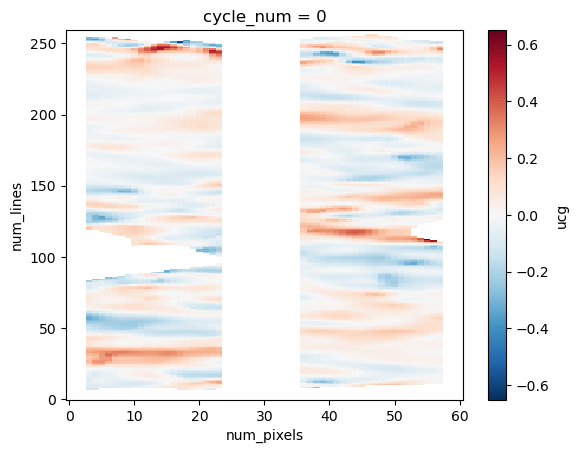

In [33]:
params = dict(derivative = 'fit', # Derivative obtained by the fitting method instead of point difference
          n = 5, # 5*5 point kernels
          min_valid_points = 0.75, # Ratio of valid points to compute the derivative (e.g. 75% valid points are necessary to compute the derivatives, useful to avoid boundary effects)
          cyclostrophy = 'GW', # Cyclogeostrophic currents are computed using the wind-gradient balance
          avoid_negative = True, # Parameter that avoid negative values in the SQRT using the GW formulation (leading to invalid values in the solutions)
          second_derivative = 'dxdy', # The second derivative is obtained by point-difference the first derivative (obtained by surface fitting method), rather than from the surface curvature. I noticed that it reduces the noise. 
          kernel = 'circular', # can be circular or a square, the shape of the kernel

)

## Diagnostics from original SSH
for cc in low16.cycle_num:
    diag = compute_ocean_diagnostics_from_eta(low16.sel(cycle_num=cc), 
                                          low16.longitude, low16.latitude, **params
                                             )
    if cc == 0:
        dsave = xr.DataArray(diag["eta_fit"], dims=low16.sel(cycle_num=cc).dims,
                             coords=low16.sel(cycle_num=cc).coords
                            ).to_dataset(name='eta_fit')
        dsave["ug"] = xr.DataArray(diag["ug"], dims=low16.sel(cycle_num=cc).dims,
                             coords=low16.sel(cycle_num=cc).coords
                            )
        dsave["vg"] = xr.DataArray(diag["vg"], dims=low16.sel(cycle_num=cc).dims,
                             coords=low16.sel(cycle_num=cc).coords
                            )
        dsave["ucg"] = xr.DataArray(diag["ucg"], dims=low16.sel(cycle_num=cc).dims,
                             coords=low16.sel(cycle_num=cc).coords
                            )
        dsave["vcg"] = xr.DataArray(diag["vcg"], dims=low16.sel(cycle_num=cc).dims,
                             coords=low16.sel(cycle_num=cc).coords
                            )
        dsave["vort"] = xr.DataArray(diag["zeta"], dims=low16.sel(cycle_num=cc).dims,
                             coords=low16.sel(cycle_num=cc).coords
                            )
        dsave["OW"] = xr.DataArray(diag["OW"], dims=low16.sel(cycle_num=cc).dims,
                             coords=low16.sel(cycle_num=cc).coords
                            )
    else:
        tmp = xr.DataArray(diag["eta_fit"], dims=low16.sel(cycle_num=cc).dims,
                             coords=low16.sel(cycle_num=cc).coords
                            ).to_dataset(name='eta_fit')
        tmp["ug"] = xr.DataArray(diag["ug"], dims=low16.sel(cycle_num=cc).dims,
                             coords=low16.sel(cycle_num=cc).coords
                            )
        tmp["vg"] = xr.DataArray(diag["vg"], dims=low16.sel(cycle_num=cc).dims,
                             coords=low16.sel(cycle_num=cc).coords
                            )
        tmp["ucg"] = xr.DataArray(diag["ucg"], dims=low16.sel(cycle_num=cc).dims,
                             coords=low16.sel(cycle_num=cc).coords
                            )
        tmp["vcg"] = xr.DataArray(diag["vcg"], dims=low16.sel(cycle_num=cc).dims,
                             coords=low16.sel(cycle_num=cc).coords
                            )
        tmp["vort"] = xr.DataArray(diag["zeta"], dims=low16.sel(cycle_num=cc).dims,
                             coords=low16.sel(cycle_num=cc).coords
                            )
        tmp["OW"] = xr.DataArray(diag["OW"], dims=low16.sel(cycle_num=cc).dims,
                             coords=low16.sel(cycle_num=cc).coords
                            )
        dsave = xr.concat([dsave, tmp], "cycle_num")
        del tmp
print(dsave)

dsave.ucg.isel(cycle_num=0).plot(rasterized=True)
plt.show()
dsave.chunk({"cycle_num":1, "num_pixels":-1, "num_lines":-1}
           ).to_zarr(op.join(ddir,
            'SWOT/CalVal/mrCOSTS_h/MedSea/Pass016/geos_Pass016_tranchant-afterDMD.zarr' 
                            ), mode='w')
dsave.close()

In [34]:
ds16l = xr.open_zarr(op.join(ddir,
            'SWOT/CalVal/mrCOSTS_h/MedSea/Pass016/geos_Pass016_no-interp_%02dpoints.zarr' 
                             % (2)
                            )
                   )
ds16t = xr.open_zarr(op.join(ddir,
            'SWOT/CalVal/mrCOSTS_h/MedSea/Pass016/geos_Pass016_tranchant-afterDMD.zarr' 
                            )
                   )
ds16l, ds16t

(<xarray.Dataset> Size: 71MB
 Dimensions:     (cycle_num: 93, num_lines: 260, num_pixels: 61)
 Coordinates:
   * cycle_num   (cycle_num) int64 744B 0 1 2 3 4 5 6 7 ... 91 92 93 94 95 96 97
   * num_lines   (num_lines) int64 2kB 0 1 2 3 4 5 6 ... 254 255 256 257 258 259
   * num_pixels  (num_pixels) int64 488B 0 1 2 3 4 5 6 7 ... 54 55 56 57 58 59 60
     latitude    (num_lines, num_pixels) float64 127kB dask.array<chunksize=(260, 61), meta=np.ndarray>
     longitude   (num_lines, num_pixels) float64 127kB dask.array<chunksize=(260, 61), meta=np.ndarray>
     time        (cycle_num, num_lines, num_pixels) datetime64[ns] 12MB dask.array<chunksize=(1, 260, 61), meta=np.ndarray>
 Data variables:
     ssha        (cycle_num, num_lines, num_pixels) float64 12MB dask.array<chunksize=(1, 260, 61), meta=np.ndarray>
     strain      (cycle_num, num_lines, num_pixels) float64 12MB dask.array<chunksize=(1, 260, 61), meta=np.ndarray>
     ug          (cycle_num, num_lines, num_pixels) float64 12MB 

2023-06-07T23:57:29.576362924


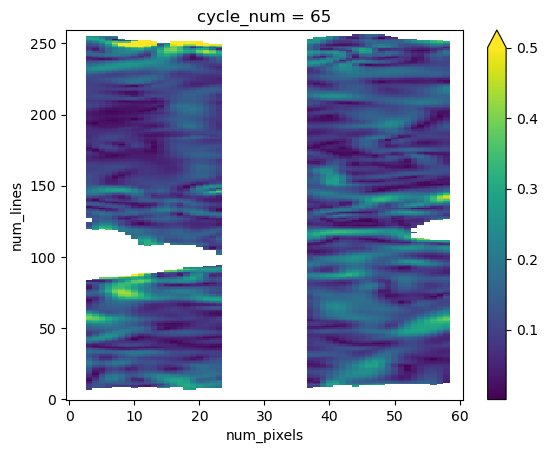

2023-06-08T23:48:07.387597230


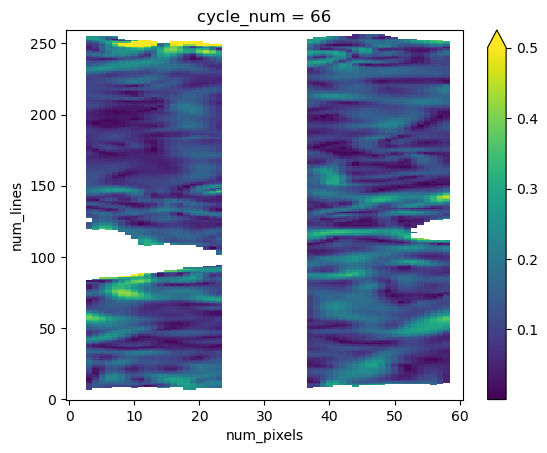

2023-06-09T23:38:45.171272308


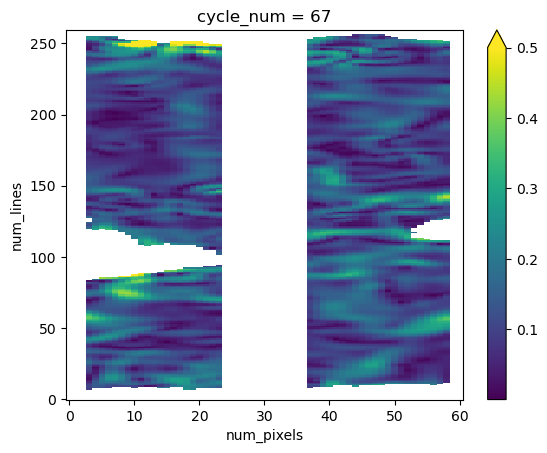

2023-06-10T23:29:22.917336386


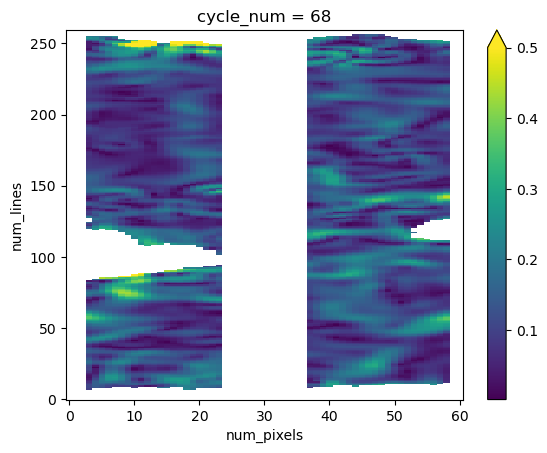

2023-06-11T23:20:00.635043754


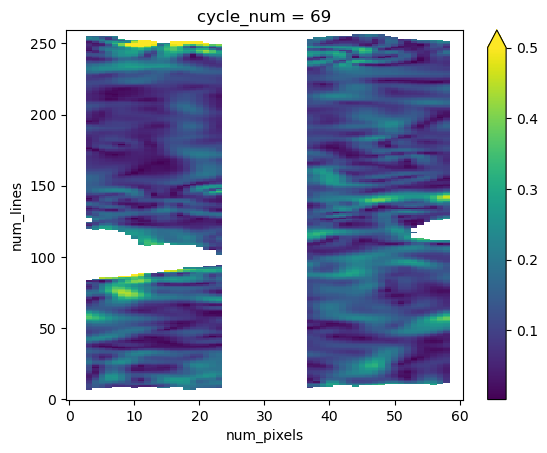

2023-06-12T23:10:38.326722284


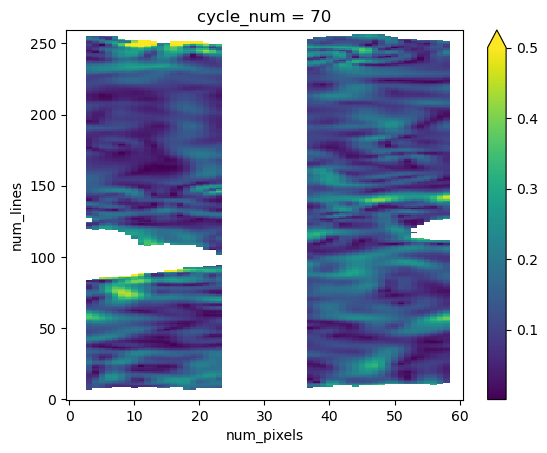

2023-06-13T23:01:15.995122536


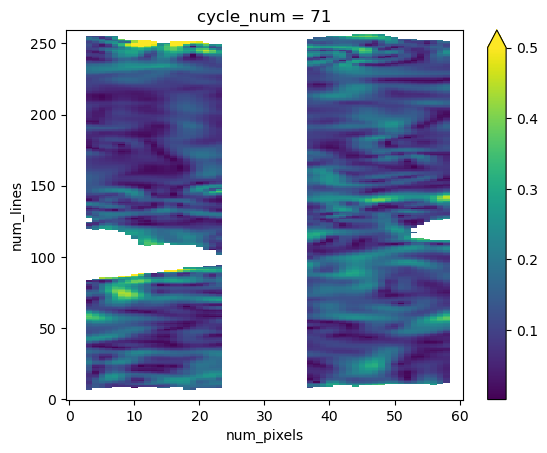

2023-06-14T22:51:53.638810662


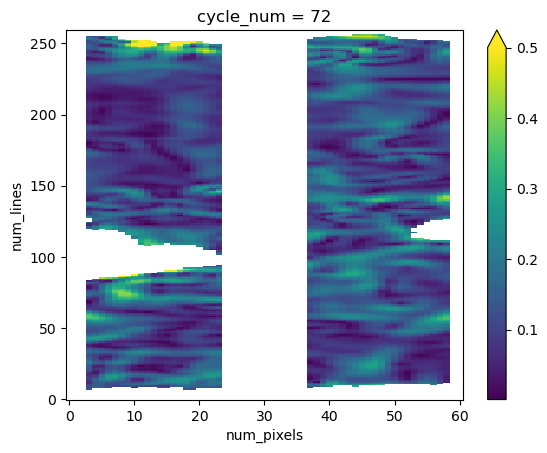

In [30]:
for cc in range(62,70):
    print(ds16l.time.isel(cycle_num=cc).mean().values)
    np.sqrt(ds16l.ug.isel(cycle_num=cc)**2 
     + ds16l.vg.isel(cycle_num=cc)**2).plot(rasterized=True, vmax=.5)
    plt.show()
    # ds3l.vg.isel(cycle_num=cc).plot(rasterized=True)
    # plt.show()

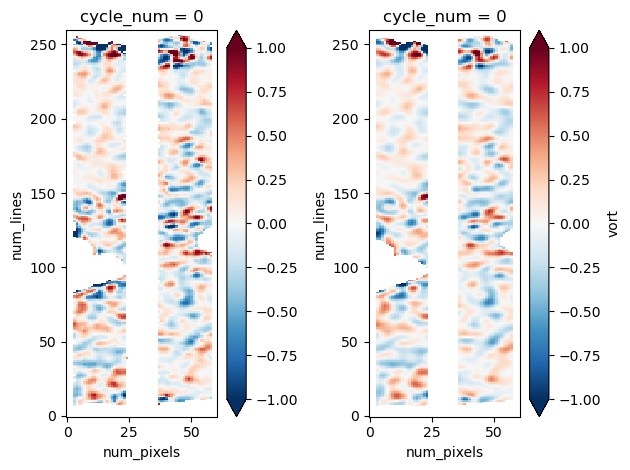

In [35]:
f = gsw.f(ds16l.vort.latitude)
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_tight_layout(True)
(ds16l.vort/f).sel(cycle_num=0).plot(ax=ax1, vmax=1, vmin=-1, 
                                cmap="RdBu_r", rasterized=True)
ds16t.vort.sel(cycle_num=0).plot(ax=ax2, vmax=1, vmin=-1, 
                                cmap="RdBu_r", rasterized=True)